
## Business Case :

ABC Tech is an mid-size organisation operation in IT-enabled business segment over a decade. On an average ABC Tech receives 22-25k IT incidents/tickets, which were handled to best practice ITIL framework with incident management, problem management, change management and configuration management processes. These ITIL practices attained matured process level and a recent audit confirmed that further improvement initiatives may not yield return of investment.

ABC Tech management is looking for ways to improve the incident management process as recent customer survey results shows that incident management is rated as poor.

Machine Learning as way to improve ITSM processes
ABC Tech management recently attended Machine Learning conference on ML for ITSM.
Machine learning looks prospective to improve ITSM processes through prediction and automation. They came up with 4 key areas, where ML can help ITSM process in ABC Tech.
1. Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.
2. Forecast the incident volume in different fields, quarterly and annual. So that they can be better prepared with resources and technology planning.
3. Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced.
4. Predict RFC (Request for change) and possible failure / misconfiguration of ITSM assets.

### Basic Checks 

In [5]:
# Importing necessary libraries
import mysql.connector
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# To decompose the data
from statsmodels.tsa.seasonal import seasonal_decompose

# Check stationarity
from statsmodels.tsa.stattools import adfuller

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer

# Train and test split
from sklearn.model_selection import train_test_split

# Forecasting models
import statsmodels.api as sm #to use ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping #used early stopping in LSTM
from croston import croston

# Hypertuning used for forecasting
from pmdarima import auto_arima
from statsmodels.tsa.stattools import arma_order_select_ic

# Pipeline
from sklearn.pipeline import Pipeline

# Classifier models
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Hypertuning used for classifier models
from sklearn.model_selection import KFold,RandomizedSearchCV

# Model evaluation 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [6]:
## making connections to database server
connection=mysql.connector.connect(host = '18.136.157.135',
                                   port = 3306,
                                   user='dm_team',
                                   password='DM!$Team@&27920!')

In [7]:
## Check the number of databases available on the server
cursor=connection.cursor()
cursor.execute('show databases')
for i in cursor:
    print(i)

('information_schema',)
('project_itsm',)


In [8]:
# making connections to project_itsm database
connection=mysql.connector.connect(host = '18.136.157.135',
                                   port = 3306,
                                   user='dm_team',
                                   password='DM!$Team@&27920!',
                                   database='project_itsm')

In [9]:
# Checking total number of tables present in project_itsm database 
db_tables=pd.read_sql_query('show tables',connection)
print(db_tables)

  Tables_in_project_itsm
0           dataset_list


In [10]:
# Loading the data using SQL statement
query = "select * from dataset_list" 
itsm_dataset = pd.read_sql(query,connection,parse_dates=['Open_Time','Reopen_Time','Resolved_Time','Close_Time'])

In [11]:
itsm_dataset.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,2012-05-02 13:32:00,NaT,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,2012-12-03 15:44:00,2013-02-12 12:31:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1,SD0000011,1,,
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,2012-03-29 12:36:00,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1,SD0000017,,,
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1,SD0000025,,,
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,2012-10-08 11:01:00,NaT,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1,SD0000029,,,


In [12]:
itsm_dataset.CI_Subcat.nunique()

65

In [13]:
itsm_dataset.CI_Subcat.value_counts()

Server Based Application           18811
Web Based Application              15311
Desktop Application                 3876
Laptop                              1921
SAP                                 1199
Banking Device                       916
Citrix                               767
SAN                                  549
Client Based Application             492
Desktop                              423
DataCenterEquipment                  277
System Software                      272
Monitor                              212
Database                             211
Windows Server                       153
Controller                           146
Exchange                             130
                                     111
Printer                               88
Omgeving                              86
Standard Application                  85
Scanner                               64
MigratieDummy                         60
Linux Server                          55
Automation Softw

In [15]:
itsm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     46606 non-null  object        
 1   CI_Cat                      46606 non-null  object        
 2   CI_Subcat                   46606 non-null  object        
 3   WBS                         46606 non-null  object        
 4   Incident_ID                 46606 non-null  object        
 5   Status                      46606 non-null  object        
 6   Impact                      46606 non-null  object        
 7   Urgency                     46606 non-null  object        
 8   Priority                    46606 non-null  object        
 9   number_cnt                  46606 non-null  object        
 10  Category                    46606 non-null  object        
 11  KB_number                   46606 non-null  object    

In [16]:
itsm_dataset.describe()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
count,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,2284,44826,46606,46606,46606,46606,46606,46606,46606,46606
unique,3019,13,65,274,46606,2,6,6,6,46606,4,1825,1,42,34636,2244,33627,34528,30639,15,50,43060,25,5,233
top,SUB000456,application,Server Based Application,WBS000073,IM0000004,Closed,4,4,4,0.601292279,incident,KM0001106,closed,0,2014-03-24 08:54:00,2013-10-29 15:03:00,2013-10-10 12:53:00,2013-02-10 15:20:00,0,Other,1,#MULTIVALUE,,,
freq,3050,32900,18811,13342,1,46597,22556,22588,22717,1,37748,1106,46606,27468,7,2,7,21,236,16470,43058,3434,45384,46046,46046
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-10 10:49:00,2013-01-10 09:58:00,2013-01-10 06:45:00,2013-01-10 06:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-03 22:58:00,2014-12-03 17:24:00,2014-12-03 17:56:00,2014-12-03 17:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
itsm_dataset.nunique()

CI_Name                        3019
CI_Cat                           13
CI_Subcat                        65
WBS                             274
Incident_ID                   46606
Status                            2
Impact                            6
Urgency                           6
Priority                          6
number_cnt                    46606
Category                          4
KB_number                      1825
Alert_Status                      1
No_of_Reassignments              42
Open_Time                     34636
Reopen_Time                    2244
Resolved_Time                 33627
Close_Time                    34528
Handle_Time_hrs               30639
Closure_Code                     15
No_of_Related_Interactions       50
Related_Interaction           43060
No_of_Related_Incidents          25
No_of_Related_Changes             5
Related_Change                  233
dtype: int64

In [18]:
print(itsm_dataset.Open_Time.min(),itsm_dataset.Open_Time.max())

2012-01-10 10:49:00 2014-12-03 22:58:00


In [19]:
itsm_dataset.shape

(46606, 25)

In [20]:
itsm_dataset[itsm_dataset.WBS == 'WBS000091'].CI_Cat.value_counts()

computer             2002
application           235
displaydevice         212
hardware               49
networkcomponents       2
Name: CI_Cat, dtype: int64

##### Observation from Basic Checks 
* Even though following columns have numerical values, they are considered as categorical.
Impact,Urgency,Priority,No_of_Reassignments,Handle_Time_hrs,No_of_Related_Interactions,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes
* There are totally 25 features and 46606 rows in the provided dataset.
* Looks like there are many empty strings present in the dataset.
* There is no ticket description and workqueue information
* we have historical data from 10th January 2012 to 3rd December 2014.

### Business case 1:  To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.

In [21]:
# Filtering the High priority tickets from the provided dataset
itsm_dataset_high_priority = itsm_dataset[(itsm_dataset.Priority == '1') | 
                                          (itsm_dataset.Priority == '2')]

In [22]:
itsm_dataset_high_priority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 849 to 46551
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     700 non-null    object        
 1   CI_Cat                      700 non-null    object        
 2   CI_Subcat                   700 non-null    object        
 3   WBS                         700 non-null    object        
 4   Incident_ID                 700 non-null    object        
 5   Status                      700 non-null    object        
 6   Impact                      700 non-null    object        
 7   Urgency                     700 non-null    object        
 8   Priority                    700 non-null    object        
 9   number_cnt                  700 non-null    object        
 10  Category                    700 non-null    object        
 11  KB_number                   700 non-null    object    

In [23]:
print(f'High priority tickets Opentime between {itsm_dataset_high_priority.Open_Time.min()} and {itsm_dataset_high_priority.Open_Time.max()}')

High priority tickets Opentime between 2013-01-10 08:18:00 and 2014-12-03 12:59:00


In [24]:
itsm_dataset_high_priority.Priority.value_counts()

2    697
1      3
Name: Priority, dtype: int64

In [25]:
# Finding the top 10 which WBS has more number of high priority tickets 
itsm_dataset_high_priority.WBS.value_counts().nlargest(10)

WBS000146    412
WBS000162     25
WBS000088     21
WBS000073     17
WBS000285     16
WBS000281     13
WBS000095     10
WBS000292      7
WBS000118      7
WBS000092      7
Name: WBS, dtype: int64

In [26]:
itsm_dataset_high_priority.WBS.nunique()

81

We have 81 WBS which have high priority tickets

In [27]:
# Finding the top 10 which CI_Subcat has more number of high priority tickets 
itsm_dataset_high_priority.CI_Subcat.value_counts().nlargest(10)

Banking Device              412
Server Based Application     96
Web Based Application        85
Desktop Application          36
Windows Server               11
Citrix                       11
Switch                       10
Router                        8
                              8
SAN                           5
Name: CI_Subcat, dtype: int64

In [28]:
# As total number of Banking Device in CI_Subcat and WBS with WBS000146 are same, let's check whether they have common rows
check_df = itsm_dataset_high_priority.query('CI_Subcat == "Banking Device"')
check_df.WBS.value_counts()

WBS000146    412
Name: WBS, dtype: int64

In [35]:
# As we have too many high priority incidents with WBS000146 where all the incidents belongs to Banking Device Subcategory, we will create new dataframe to forecast
df = itsm_dataset_high_priority.query("WBS in 'WBS000146'")
df['Hourly_Frequency_created_time'] = df['Open_Time'].round('H')
df.set_index('Hourly_Frequency_created_time', inplace=True)
df = df[['CI_Subcat']]

In [36]:
df.head()

,CI_Subcat
Hourly_Frequency_created_time,
2013-01-10 10:00:00,Banking Device
2013-01-10 10:00:00,Banking Device
2013-01-10 10:00:00,Banking Device
2013-01-10 09:00:00,Banking Device
2013-01-10 11:00:00,Banking Device


In [37]:
df.CI_Subcat.value_counts()

Banking Device    412
Name: CI_Subcat, dtype: int64

So we have only incidents which is taken care by group which takes care of "Banking Device" subcategory

In [38]:
# Resampling df and creating new dataframe
df_sample = df.groupby('CI_Subcat').resample('D').count().fillna(0)

In [39]:
df_sample.head()

CI_Subcat
CI_Subcat      Hourly_Frequency_created_time           
Banking Device 2013-01-10                             8
               2013-01-11                             4
               2013-01-12                             0
               2013-01-13                             0
               2013-01-14                             0

In [40]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 693 entries, ('Banking Device', Timestamp('2013-01-10 00:00:00', freq='D')) to ('Banking Device', Timestamp('2014-12-03 00:00:00', freq='D'))
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   CI_Subcat  693 non-null    int64
dtypes: int64(1)
memory usage: 29.3+ KB


In [41]:
# Unstacking the data for creating multiple columns and filling null values with 0
df_sample = df_sample.unstack(level=0).fillna(0)

In [42]:
df_sample

,CI_Subcat
CI_Subcat,Banking Device
Hourly_Frequency_created_time,
2013-01-10,8
2013-01-11,4
2013-01-12,0
2013-01-13,0
2013-01-14,0
...,...
2014-11-29,0
2014-11-30,0


In [43]:
# Dropping level 0 columns from the created dataframe
df_sample = df_sample.droplevel(level=0, axis=1)

In [44]:
# setting the frequency of the index to daily
df_sample.index.freq = 'D'
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 693 entries, 2013-01-10 to 2014-12-03
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Banking Device  693 non-null    int64
dtypes: int64(1)
memory usage: 10.8 KB


In [45]:
df_sample.index

DatetimeIndex(['2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13',
               '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17',
               '2013-01-18', '2013-01-19',
               ...
               '2014-11-24', '2014-11-25', '2014-11-26', '2014-11-27',
               '2014-11-28', '2014-11-29', '2014-11-30', '2014-12-01',
               '2014-12-02', '2014-12-03'],
              dtype='datetime64[ns]', name='Hourly_Frequency_created_time', length=693, freq='D')

In [46]:
df_sample.head(5)

CI_Subcat,Banking Device
Hourly_Frequency_created_time,
2013-01-10,8
2013-01-11,4
2013-01-12,0
2013-01-13,0
2013-01-14,0


In [47]:
df_sample.index.min(),df_sample.index.max()

(Timestamp('2013-01-10 00:00:00', freq='D'),
 Timestamp('2014-12-03 00:00:00', freq='D'))

##### Exploratory Data Analysis

In [37]:
df_sample.columns

Index(['Banking Device'], dtype='object', name='CI_Subcat')

In [37]:
# Creating function to plot all columns
def plot_columns(df_sample,total_subplots):
    plt.rcParams.update({'figure.figsize': (20,10)})
    plotnumber = 1
    for column in df_sample.columns:
        ax = plt.subplot(total_subplots,1,plotnumber)
        df_sample[column].plot()
        plt.title(column)
        plt.xlabel("Date")
        plt.ylabel("Ticket Count")
        plotnumber += 1
        plt.tight_layout()
        plt.show()

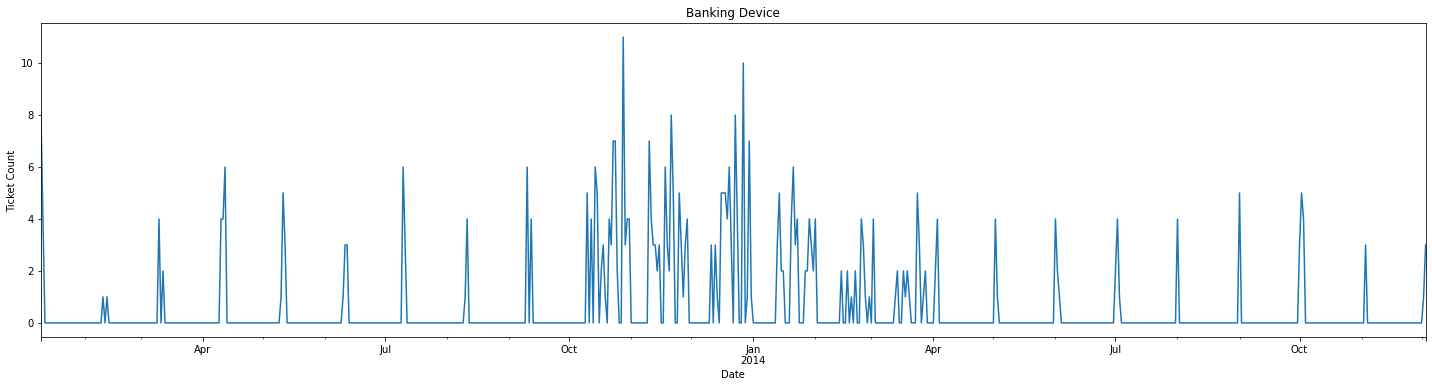

In [39]:
# Plotting all the columns
plot_columns(df_sample,2) #just to adjust the size of the image 2 is passed as argument

We received more number of high priority tickets between October 2013 and April 2014

In [38]:
# Decomposing the time series data

# As Multiplicative seasonality is not appropriate for zero and negative values, Additive decomposition is performed

#Creating function to do additive decompose
def decompose_additive(df,total_subplots):
    plt.rcParams.update({'figure.figsize': (20,40)})
    plotnumber = 1
    for column in df.columns:
        ax = plt.subplot(total_subplots,1,plotnumber)
        add_result = seasonal_decompose(df[column], model='additive',period=1)
        add_result.observed.plot()
        plt.title(f'{column} -  observed')
        plotnumber += 1
        ax = plt.subplot(total_subplots,1,plotnumber)
        add_result.trend.plot()
        plt.title(f'{column} -  trend')
        plotnumber += 1
        ax = plt.subplot(total_subplots,1,plotnumber)
        add_result.seasonal.plot()
        plt.title(f'{column} -  seasonal')
        plotnumber += 1
        ax = plt.subplot(total_subplots,1,plotnumber)
        add_result.resid.plot()
        plt.title(f'{column} -  residuals')
        plotnumber += 1
    plt.tight_layout()
    plt.show()

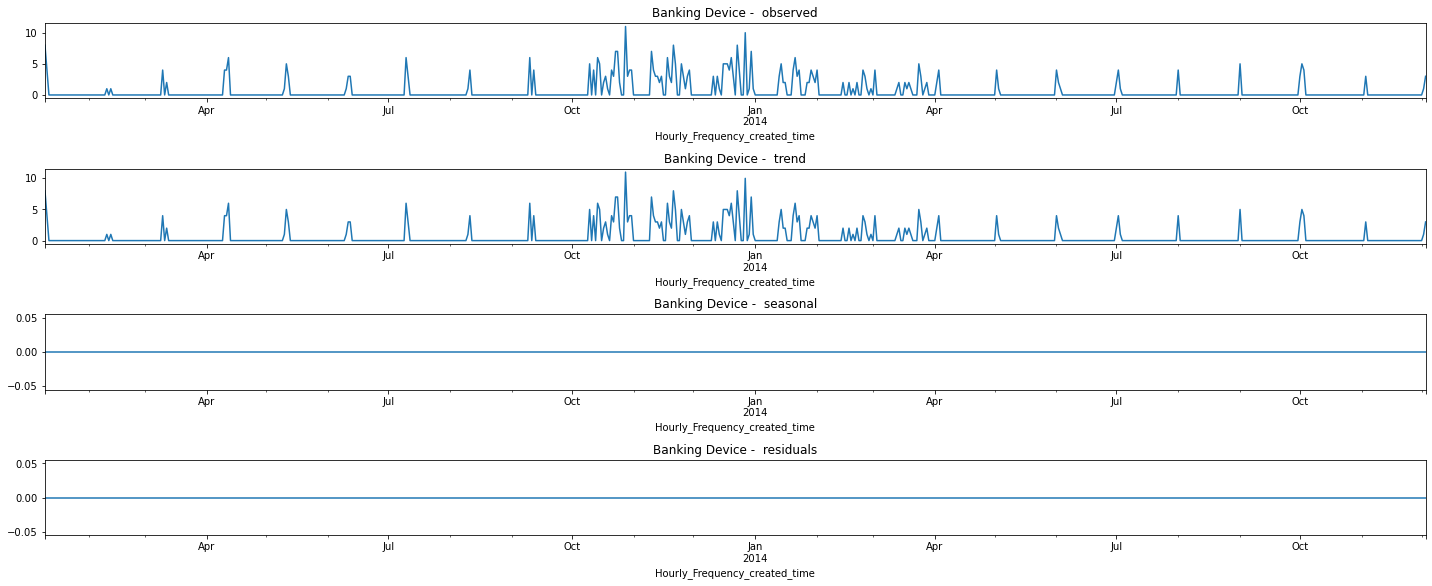

In [41]:
# Decomposing the time series data
decompose_additive(df_sample,20)#just to adjust the size of the image 20 is passed as argument

* Only Horizontal Trend component is present
* we can ensure that data doesn't have seasonality

In [36]:
# Creating function to check stationarity
def check_stationarity(df_sample):
    for i in range(len(df_sample.columns)):
        result = adfuller(df_sample[df_sample.columns[i]])

        if result[1] > 0.05 :
            print('{} - Series is not Stationary'.format(df_sample.columns[i]))
        else:
            print('{} - Series is Stationary'.format(df_sample.columns[i]))

In [43]:
# Check for stationarity
check_stationarity(df_sample)

Banking Device - Series is Stationary


###### Train and Test Split

In [44]:
df_train = df_sample[:'2014-05-31']
df_test = df_sample['2014-06-01':]

In [45]:
df_sample.index.min(),df_sample.index.max()

(Timestamp('2013-01-10 00:00:00', freq='D'),
 Timestamp('2014-12-03 00:00:00', freq='D'))

In [46]:
df_train

CI_Subcat,Banking Device
Hourly_Frequency_created_time,
2013-01-10,8
2013-01-11,4
2013-01-12,0
2013-01-13,0
2013-01-14,0
...,...
2014-05-27,0
2014-05-28,0
2014-05-29,0


In [47]:
df_train.shape

(507, 1)

In [48]:
df_test.shape

(186, 1)

In [49]:
df_train.index.min(),df_train.index.max()

(Timestamp('2013-01-10 00:00:00', freq='D'),
 Timestamp('2014-05-31 00:00:00', freq='D'))

In [50]:
df_test.index.min(),df_test.index.max()

(Timestamp('2014-06-01 00:00:00', freq='D'),
 Timestamp('2014-12-03 00:00:00', freq='D'))

In [51]:
df_train.columns

Index(['Banking Device'], dtype='object', name='CI_Subcat')

#### Model Creation

In [321]:
# Finding optimum time series model with parameters
stepwise_fit = auto_arima(df_train['Banking Device'], start_p=0, start_q=0,
                          max_p=10, max_q=10, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2070.675, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1998.609, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1899.883, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2068.711, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1881.038, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1882.960, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1882.017, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1881.958, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1935.614, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1882.963, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1879.123, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1897.983, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1996.668, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1881.043, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  507
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -936.561
Date:                Wed, 28 Dec 2022   AIC                           1879.123
Time:                        13:35:07   BIC                           1891.802
Sample:                    01-10-2013   HQIC                          1884.096
                         - 05-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2748      0.034      7.989      0.000       0.207       0.342
ma.L1         -0.9506      0.012    -81.690      0.000      -0.973      -0.928
sigma2         2.3640      0.082     28.973      0.000       2.204       2.524
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1887.65
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Model Creation
model_sarima = SARIMAX(df_train, order=(1,1,1))
model_sarimax_fit = model_sarima.fit()

In [53]:
# Forecast the data
sarima_forecast = model_sarimax_fit.forecast(steps=300)

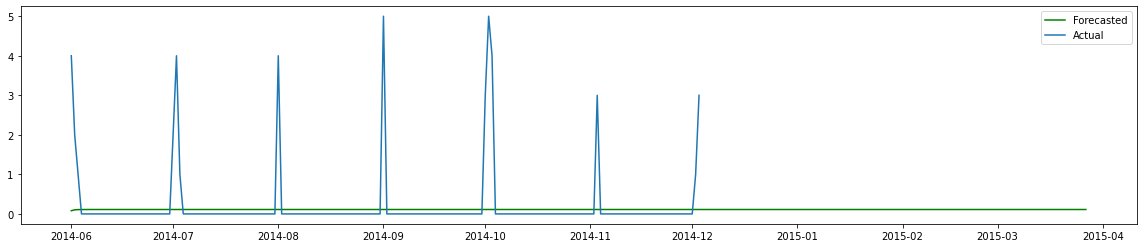

In [54]:
# Visualize Forecasted vs Actual
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(sarima_forecast,color='green')
plt.plot(df_test)
plt.legend(["Forecasted","Actual"])

SARIMAX Model is not performing well

###### Using ARMA model

In [327]:
# to find orders for ARMA models on stationary data.
arma_order_select_ic(df_train['Banking Device'])

{'bic':              0            1            2
 0  1991.648113  1928.931360  1929.395802
 1  1913.836018  1901.122179  1900.114980
 2  1915.256972  1901.775250  1904.197741
 3  1902.582494  1904.866896  1910.177446
 4  1906.689057  1912.616125  1905.582405,
 'bic_min_order': (1, 2)}

In [56]:
# Model creation
model = sm.tsa.arima.ARIMA(df_train, order=(1,0,2))
model_arima_fit = model.fit()

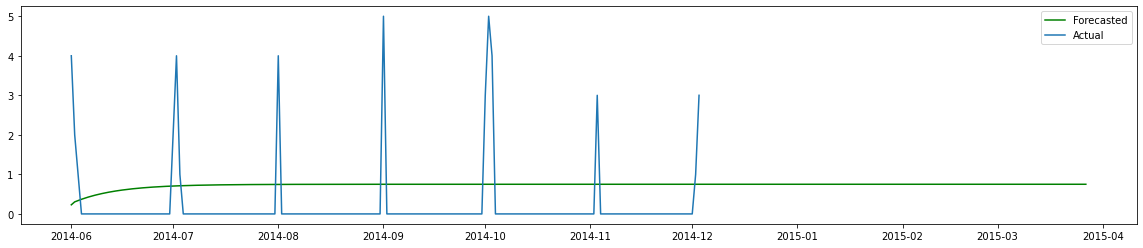

In [58]:
# Forecast and visualize forecasted data vs actual data
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_test)
plt.legend(["Forecasted","Actual"])

###### Model is not performing good, so we will find out the P and Q value using PACF and ACF

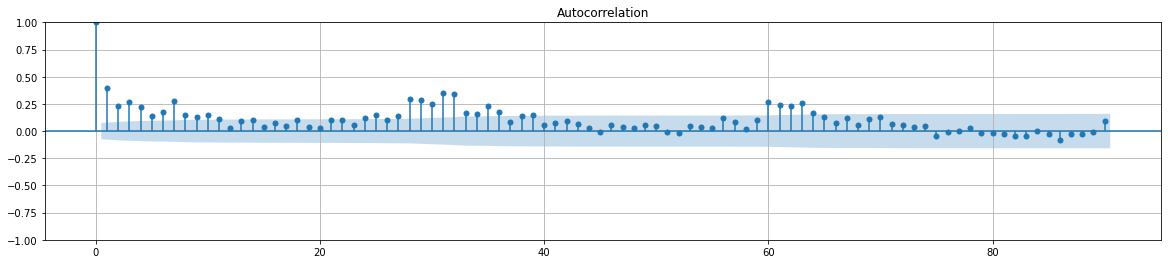

In [331]:
plot_acf(df_sample,lags=90);
plt.grid()

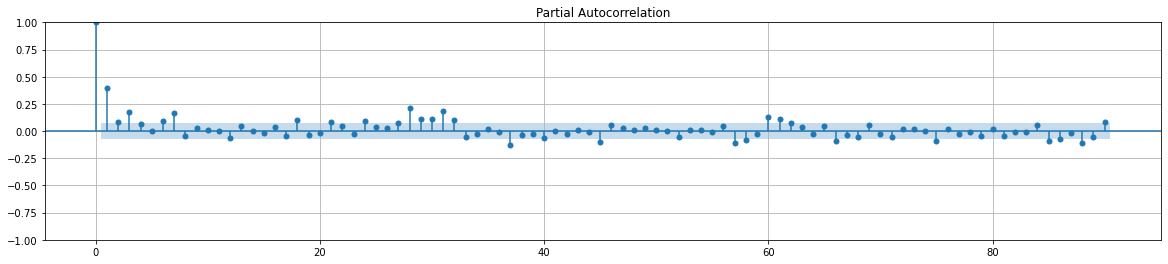

In [332]:
plot_pacf(df_sample,lags=90);
plt.grid()

In [112]:
# Hypertuning p and q value using for loop
p_values = [1,28,30,31,32,61]
q_values = [1,3,7,28,29,30,31,32]

for p in p_values:
    for q in q_values:
        model = sm.tsa.arima.ARIMA(df_train, order=(p,0,q))
        model_arima_fit = model.fit()
        arima_predict = model_arima_fit.forecast(steps=len(df_test))
        print(f"RMSE with {p} and {q}: ",sqrt(mean_squared_error(df_test,arima_predict)))

RMSE with 1 and 1:  1.0268353218118005
RMSE with 1 and 3:  1.0235501474662467
RMSE with 1 and 7:  1.0285583127981643
RMSE with 1 and 28:  1.0069679910623506
RMSE with 1 and 29:  1.007302147769317
RMSE with 1 and 30:  1.0032831032365288
RMSE with 1 and 31:  1.0179361832621676
RMSE with 1 and 32:  1.0045763484837265
RMSE with 28 and 1:  0.898662504258114
RMSE with 28 and 3:  0.9051248321608
RMSE with 28 and 7:  0.9197866647293939
RMSE with 28 and 28:  0.8503433362435533
RMSE with 28 and 29:  0.8804517656619292
RMSE with 28 and 30:  0.9173554760440855
RMSE with 28 and 31:  0.8918402475997728
RMSE with 28 and 32:  0.9360646344807423
RMSE with 30 and 1:  0.895870645853696
RMSE with 30 and 3:  0.8755721381495767
RMSE with 30 and 7:  0.9210145538783311
RMSE with 30 and 28:  0.9161698698899526
RMSE with 30 and 29:  0.9119264729311202
RMSE with 30 and 30:  0.8613059130084809
RMSE with 30 and 31:  0.8650181217641284
RMSE with 30 and 32:  0.8645695551967428
RMSE with 31 and 1:  0.8951975725612051

In [59]:
# Model creation
model = sm.tsa.arima.ARIMA(df_train, order=(61,0,29))
model_arima_fit = model.fit()

In [60]:
# forecast the data
arima_predict = model_arima_fit.forecast(steps=300)

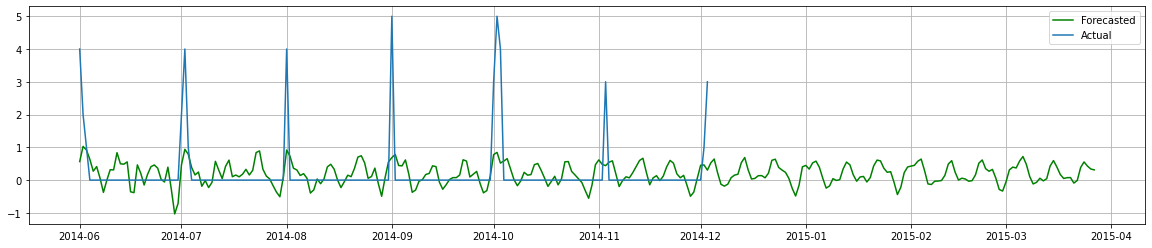

In [61]:
# Visualize forecasted data vs Actual
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

By looking into above plot, looks like there are too many false predictions

In [62]:
# Using one of the better model found by hypertuning
model = sm.tsa.arima.ARIMA(df_train, order=(28,0,28))
model_arima_fit = model.fit()

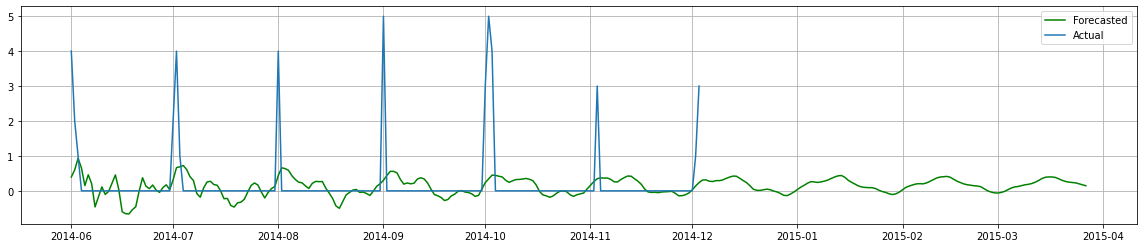

In [63]:
# Forecast and Visualize the forecasted data vs actual data
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

By looking into above plot, looks like there are too many false predictions

In [64]:
# Using the one of the better model found using hypertuning
model = sm.tsa.arima.ARIMA(df_train, order=(30,0,30))
model_arima_fit = model.fit()

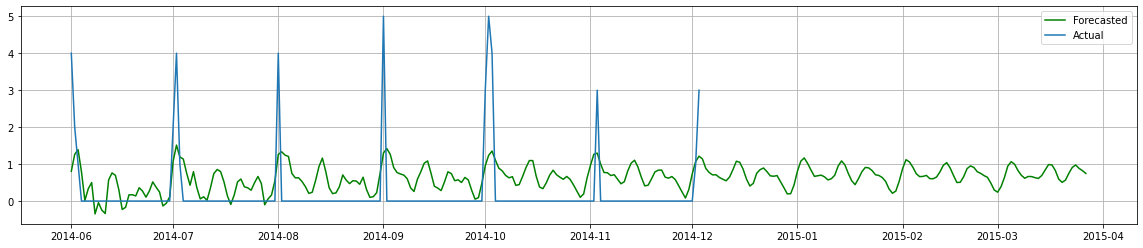

In [65]:
# Forecast and visualize the forecasted vs actual data
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

This model performs better when compared to other hypertuned models

In [66]:
df_test.index.max()

Timestamp('2014-12-03 00:00:00', freq='D')

In [67]:
arima_predict['2014-12-03':'2015-01-10']

2014-12-03    1.213830
2014-12-04    1.140770
2014-12-05    0.882749
2014-12-06    0.771890
2014-12-07    0.707974
2014-12-08    0.711739
2014-12-09    0.638013
2014-12-10    0.591419
2014-12-11    0.548670
2014-12-12    0.650302
2014-12-13    0.852177
2014-12-14    1.078326
2014-12-15    1.048901
2014-12-16    0.861106
2014-12-17    0.591039
2014-12-18    0.406130
2014-12-19    0.480268
2014-12-20    0.753449
2014-12-21    0.849370
2014-12-22    0.894459
2014-12-23    0.797596
2014-12-24    0.682070
2014-12-25    0.671776
2014-12-26    0.688894
2014-12-27    0.528599
2014-12-28    0.364615
2014-12-29    0.195437
2014-12-30    0.198717
2014-12-31    0.433838
2015-01-01    0.807610
2015-01-02    1.079432
2015-01-03    1.167304
2015-01-04    1.018050
2015-01-05    0.839836
2015-01-06    0.668459
2015-01-07    0.686251
2015-01-08    0.701039
2015-01-09    0.653987
2015-01-10    0.571390
Freq: D, Name: predicted_mean, dtype: float64

#### By looking into plot and values, we might receive high/critical priority ticket for WBS000146 between 1 to 5th Jan 2015.

In [157]:
print("RMSE : ",sqrt(mean_squared_error(df_test,arima_predict[:df_test.shape[0]])))

RMSE :  0.8613059130084809


###### Using  Prophet

In [69]:
#  Creating dataframe as required by Prophet library
df = df_sample.reset_index()
df.columns = ['ds','y']

In [70]:
df.head()

,ds,y
0,2013-01-10,8
1,2013-01-11,4
2,2013-01-12,0
3,2013-01-13,0
4,2013-01-14,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      693 non-null    datetime64[ns]
 1   y       693 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


In [73]:
# Train and test split
train = df[:len(df_train)]
test = df[len(df_train):]

In [74]:
train.head()

,ds,y
0,2013-01-10,8
1,2013-01-11,4
2,2013-01-12,0
3,2013-01-13,0
4,2013-01-14,0


In [75]:
test.head()

,ds,y
507,2014-06-01,4
508,2014-06-02,2
509,2014-06-03,1
510,2014-06-04,0
511,2014-06-05,0


In [76]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=300,freq='D')
forecast = m.predict(future)

09:09:54 - cmdstanpy - INFO - Chain [1] start processing
09:09:55 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
802,2015-03-23,-1.608929,-3.420124,0.631353,-2.248217,-1.060676,0.364011,0.364011,0.364011,0.364011,0.364011,0.364011,0.0,0.0,0.0,-1.244918
803,2015-03-24,-1.615425,-3.576690,0.487496,-2.257241,-1.064390,0.127338,0.127338,0.127338,0.127338,0.127338,0.127338,0.0,0.0,0.0,-1.488087
804,2015-03-25,-1.621921,-3.569195,0.442744,-2.265960,-1.069272,0.001717,0.001717,0.001717,0.001717,0.001717,0.001717,0.0,0.0,0.0,-1.620204
805,2015-03-26,-1.628417,-3.671425,0.833810,-2.274799,-1.073944,0.233901,0.233901,0.233901,0.233901,0.233901,0.233901,0.0,0.0,0.0,-1.394516
806,2015-03-27,-1.634913,-3.422178,0.576361,-2.283637,-1.078002,0.123708,0.123708,0.123708,0.123708,0.123708,0.123708,0.0,0.0,0.0,-1.511205


<AxesSubplot:xlabel='ds'>

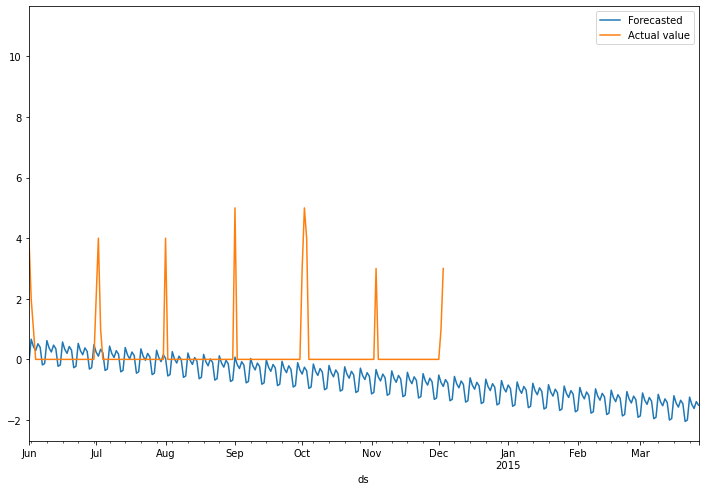

In [78]:
ax = forecast.plot(x='ds',y='yhat',label='Forecasted',legend=True,figsize=(12,8))
df.plot(x='ds',y='y',label='Actual value',legend=True,ax=ax,xlim=('2014-06-01','2015-03-27'))

In [79]:
forecast.yhat[len(df_train):len(df)]

507   -0.091395
508    0.664957
509    0.421788
510    0.289671
511    0.515359
         ...   
688   -1.320202
689   -1.273699
690   -0.517346
691   -0.760516
692   -0.892633
Name: yhat, Length: 186, dtype: float64

In [80]:
print("RMSE : ",sqrt(mean_squared_error(df_test,forecast.yhat[len(df_train):len(df)])))

RMSE :  1.0805604567958629


Prophet model is not performing better than ARMA model

###### Using Long Short Term Memory (LSTM) Networks

In [256]:
# Scaling the data using Minmax scaler
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [257]:
# Using time generator to create input
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [258]:
len(scaled_train)

507

In [259]:
len(generator) # n_input = 30

477

In [263]:
# Looking at 25th batch to ensure generated value is generated as expected
X,y = generator[25]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.         0.         0.         0.         0.
 0.09090909 0.         0.09090909 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Predict this y: 
 [[0.]]


In [265]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [266]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
477/477 [==============================] - 10s 13ms/step - loss: 0.0216
Epoch 2/50
477/477 [==============================] - 6s 13ms/step - loss: 0.0208
Epoch 3/50
477/477 [==============================] - 6s 13ms/step - loss: 0.0203
Epoch 4/50
477/477 [==============================] - 6s 13ms/step - loss: 0.0202
Epoch 5/50
477/477 [==============================] - 6s 12ms/step - loss: 0.0201
Epoch 6/50
477/477 [==============================] - 5s 11ms/step - loss: 0.0203
Epoch 7/50
477/477 [==============================] - 6s 12ms/step - loss: 0.0201
Epoch 8/50
477/477 [==============================] - 5s 11ms/step - loss: 0.0202
Epoch 9/50
477/477 [==============================] - 5s 11ms/step - loss: 0.0198
Epoch 10/50
477/477 [==============================] - 5s 11ms/step - loss: 0.0201
Epoch 11/50
477/477 [==============================] - 6s 12ms/step - loss: 0.0200
Epoch 12/50
477/477 [==============================] - 5s 11ms/step - loss: 0.0200
Epoch 13/50


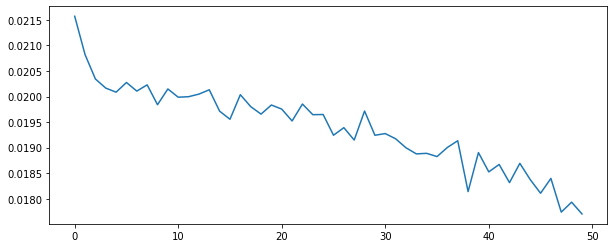

In [267]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [268]:
# Predicting test
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 50ms/step


In [269]:
test_predictions

[array([0.0171526], dtype=float32),
 array([0.01919271], dtype=float32),
 array([0.02010677], dtype=float32),
 array([0.02055282], dtype=float32),
 array([0.02081868], dtype=float32),
 array([0.02099725], dtype=float32),
 array([0.0211242], dtype=float32),
 array([0.02121654], dtype=float32),
 array([0.02128425], dtype=float32),
 array([0.02133399], dtype=float32),
 array([0.02137047], dtype=float32),
 array([0.02139716], dtype=float32),
 array([0.02141664], dtype=float32),
 array([0.02143079], dtype=float32),
 array([0.021441], dtype=float32),
 array([0.02144833], dtype=float32),
 array([0.02145353], dtype=float32),
 array([0.02145719], dtype=float32),
 array([0.02145975], dtype=float32),
 array([0.02146149], dtype=float32),
 array([0.02146266], dtype=float32),
 array([0.02146343], dtype=float32),
 array([0.02146371], dtype=float32),
 array([0.02146382], dtype=float32),
 array([0.02146382], dtype=float32),
 array([0.02146365], dtype=float32),
 array([0.02146334], dtype=float32),
 arra

In [270]:
len(test_predictions)

186

In [282]:
# Evaluate the model performance
true_predictions = scaler.inverse_transform(test_predictions)
print("RMSE : ",sqrt(mean_squared_error(df_test,true_predictions)))

RMSE :  0.8767918959236543


<AxesSubplot:xlabel='Hourly_Frequency_created_time'>

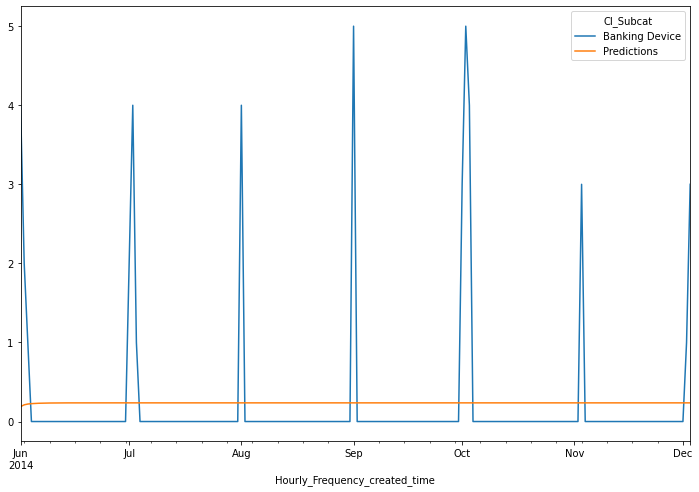

In [284]:
# Adding predictions to df_test dataframe
df_test['Predictions'] = true_predictions

# Visualizing the prediction
df_test.plot(figsize=(12,8))

 LSTM model is also not performing better than ARMA model

##### Using Croston model as the column  have lot of periodic zero data

In [246]:
# Model creation 
fit_pred = croston.fit_croston(df_train, forecast_length=300)

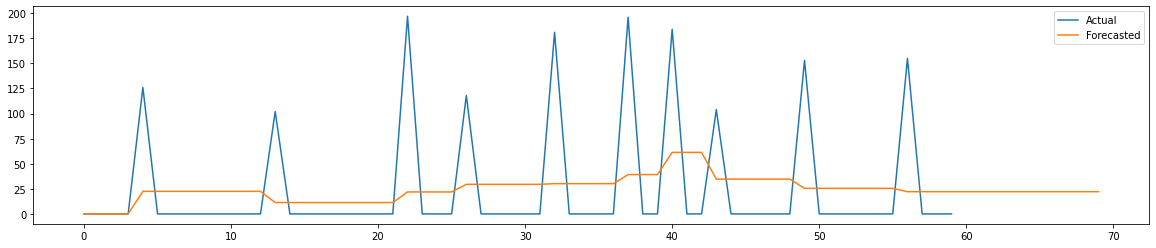

In [247]:
# Plotting the result 
y_hat_fitted = fit_pred['croston_fittedvalues'].tolist()
y_hat_forecasted = fit_pred['croston_forecast'].tolist()
y_hat = y_hat_fitted + y_hat_forecasted
plt.plot(ts)
plt.plot(yhat)
plt.legend(["Actual","Forecasted"])

In [250]:
print("RMSE : ",sqrt(mean_squared_error(df_test,y_hat_forecasted[:len(df_test)])))

RMSE :  1.0713453094195955


Croston model didnt perform well

#### ARMA Model performed better when compared to other models with RMSE score 0.86,  Based on the forecast, we might receive high/critical priority ticket for WBS000146 between 1 to 5th Jan 2015.

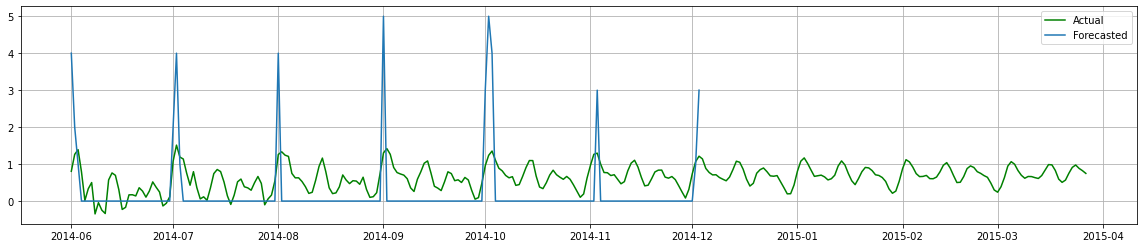

In [351]:
#Plotting the result
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_test)
plt.grid()
plt.legend(['Actual','Forecasted'])

We have spikes in forecasted value because of uncertainity in provided timeseries data

### Business case 2:  Forecast the incident volume in different fields, quarterly and annual. So that they can be better prepared with resources and technology planning.

In [18]:
# Filtering the High priority tickets from the provided dataset
incident_filtered = itsm_dataset.query("Category == 'incident'")[['CI_Subcat','Open_Time']]

In [19]:
incident_filtered.head()

,CI_Subcat,Open_Time
0,Web Based Application,2012-05-02 13:32:00
1,Web Based Application,2012-12-03 15:44:00
3,Web Based Application,2012-07-17 11:49:00
4,Web Based Application,2012-10-08 11:01:00
5,Web Based Application,2012-10-08 11:27:00


<AxesSubplot:>

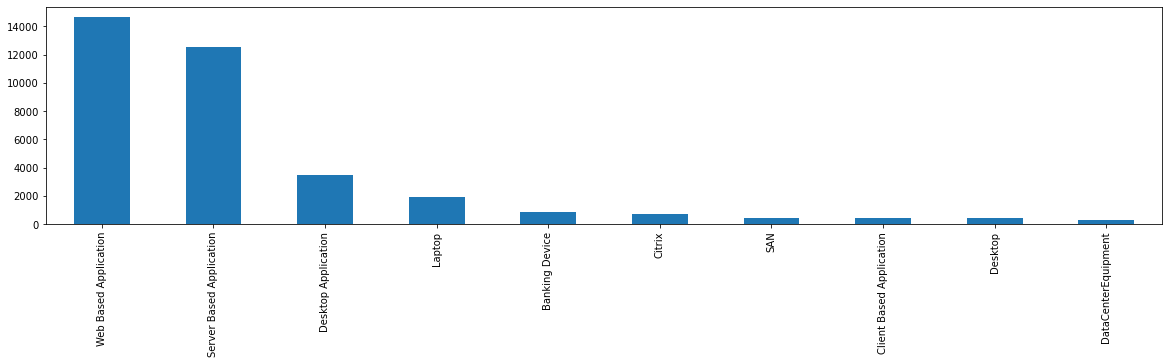

In [20]:
# Visualizing the count of top ten categories present in the dataset with high priority
plt.rcParams["figure.figsize"] = (20,4)
incident_filtered.CI_Subcat.value_counts().nlargest(10).plot(kind = 'bar')

In [21]:
dict(incident_filtered.CI_Subcat.value_counts().nlargest(6)).keys()

dict_keys(['Web Based Application', 'Server Based Application', 'Desktop Application', 'Laptop', 'Banking Device', 'Citrix'])

In [22]:
incident_filtered.CI_Subcat.value_counts().nlargest(10)

Web Based Application       14650
Server Based Application    12574
Desktop Application          3499
Laptop                       1905
Banking Device                868
Citrix                        764
SAN                           476
Client Based Application      432
Desktop                       417
DataCenterEquipment           276
Name: CI_Subcat, dtype: int64

In [23]:
incident_filtered.Open_Time.min(), incident_filtered.Open_Time.max()

(Timestamp('2012-01-10 10:49:00'), Timestamp('2014-12-03 22:58:00'))

We have data from 10th January 2012 to 3rd December 2014, ie. 3 years historical data

In [24]:
# Filtering out the rows required for forecasting
incident_filtered = incident_filtered.query("CI_Subcat in (['Web Based Application', 'Server Based Application', 'Desktop Application', 'Laptop', 'Banking Device','Citrix'])")
# setting open time as index 
incident_filtered =  incident_filtered.set_index('Open_Time')

In [25]:
# Segregating data as Quarterly and Annualy
incidents_quarterly = incident_filtered.groupby('CI_Subcat').resample('Q').count().fillna(0)
incidents_annually = incident_filtered.groupby('CI_Subcat').resample('A').count().fillna(0)

In [26]:
incidents_quarterly

CI_Subcat
CI_Subcat                Open_Time            
Banking Device           2013-03-31         56
                         2013-06-30         63
                         2013-09-30         51
                         2013-12-31        379
                         2014-03-31        214
                         2014-06-30         35
                         2014-09-30         40
                         2014-12-31         30
Citrix                   2013-03-31         42
                         2013-06-30         40
                         2013-09-30         49
                         2013-12-31        276
                         2014-03-31        257
                         2014-06-30         40
                         2014-09-30         34
                         2014-12-31         26
Desktop Application      2012-09-30          1
                         2012-12-31          0
                         2013-03-31        214
                         2013-06-30        187
                         2013-09-30        269
                         2013-12-31       1250
                         2014-03-31       1092
                         2014-06-30        157
                         2014-09-30        114
                         2014-12-31        215
Laptop                   2013-03-31        104
                         2013-06-30        105
                         2013-09-30        146
                         2013-12-31        704
                         2014-03-31        564
                         2014-06-30        124
                         2014-09-30         58
                         2014-12-31        100
Server Based Application 2012-12-31          1
                         2013-03-31        620
                         2013-06-30        774
                         2013-09-30        828
                         2013-12-31       4197
                         2014-03-31       4279
                         2014-06-30        693
                         2014-09-30        504
                         2014-12-31        678
Web Based Application    2012-03-31          3
                         2012-06-30          2
                         2012-09-30          5
                         2012-12-31          8
                         2013-03-31        738
                         2013-06-30        895
                         2013-09-30        928
                         2013-12-31       4794
                         2014-03-31       5059
                         2014-06-30        943
                         2014-09-30        522
                         2014-12-31        753

In [27]:
incidents_annually

CI_Subcat
CI_Subcat                Open_Time            
Banking Device           2013-12-31        549
                         2014-12-31        319
Citrix                   2013-12-31        407
                         2014-12-31        357
Desktop Application      2012-12-31          1
                         2013-12-31       1920
                         2014-12-31       1578
Laptop                   2013-12-31       1059
                         2014-12-31        846
Server Based Application 2012-12-31          1
                         2013-12-31       6419
                         2014-12-31       6154
Web Based Application    2012-12-31         18
                         2013-12-31       7355
                         2014-12-31       7277

In [28]:
# Unstacking the data for creating multiple columns and filling null values with 0
df_quarterly= incidents_quarterly.unstack(level=0).fillna(0)
df_annually= incidents_annually.unstack(level=0).fillna(0)
# Dropping level 0 columns from the created dataframe
df_quarterly = df_quarterly.droplevel(level=0, axis=1)
df_annually = df_annually.droplevel(level=0, axis=1)

In [29]:
df_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-03-31,0.0,0.0,0.0,0.0,0.0,3.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,0.0,1.0,0.0,0.0,5.0
2012-12-31,0.0,0.0,0.0,0.0,1.0,8.0
2013-03-31,56.0,42.0,214.0,104.0,620.0,738.0
2013-06-30,63.0,40.0,187.0,105.0,774.0,895.0
2013-09-30,51.0,49.0,269.0,146.0,828.0,928.0
2013-12-31,379.0,276.0,1250.0,704.0,4197.0,4794.0
2014-03-31,214.0,257.0,1092.0,564.0,4279.0,5059.0


We dont have enough number of tickets captured during 2012, so we will ignore 2012 data

In [30]:
df_annually

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-12-31,0.0,0.0,1.0,0.0,1.0,18.0
2013-12-31,549.0,407.0,1920.0,1059.0,6419.0,7355.0
2014-12-31,319.0,357.0,1578.0,846.0,6154.0,7277.0


We dont have enough number of tickets captured during 2012, so we will ignore 2012 data

###### Exploratory Data Analysis

In [31]:
df_quarterly.columns

Index(['Banking Device', 'Citrix', 'Desktop Application', 'Laptop',
       'Server Based Application', 'Web Based Application'],
      dtype='object', name='CI_Subcat')

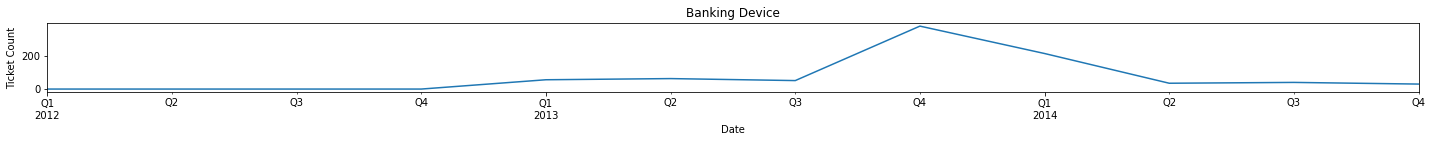

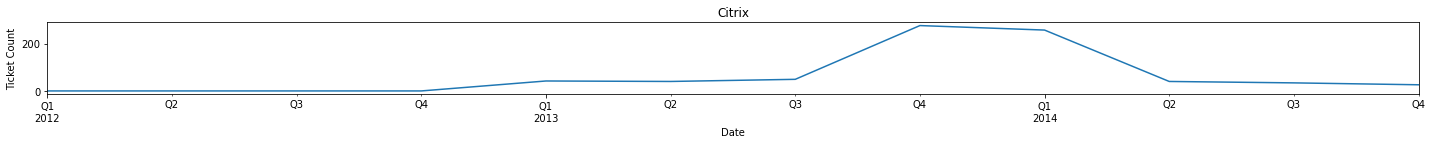

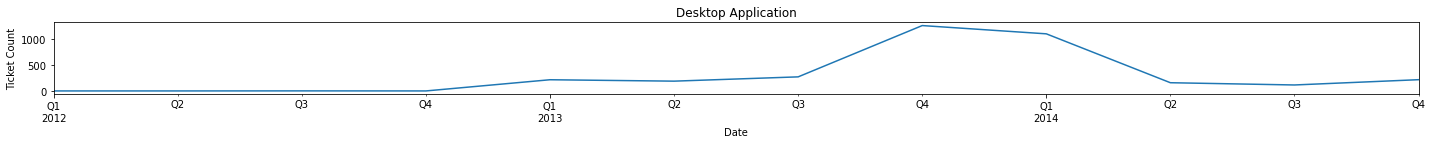

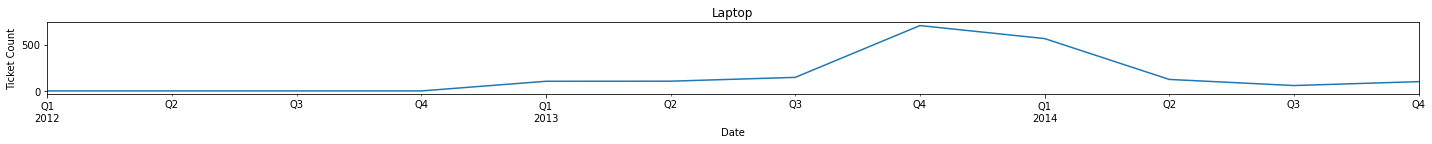

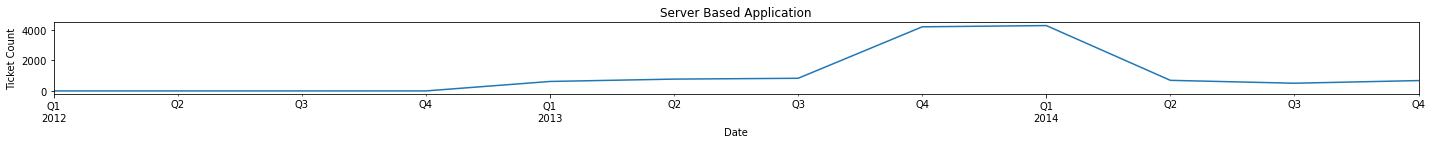

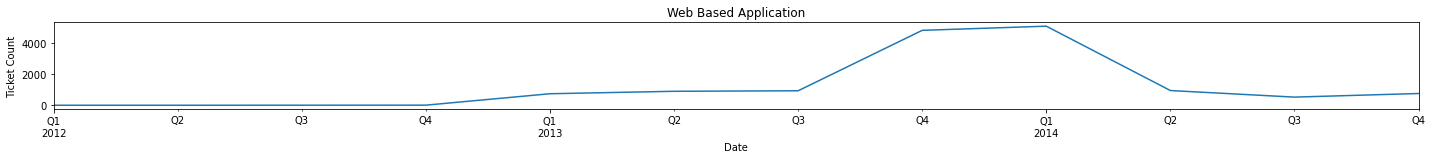

In [39]:
# Plotting all the columns from the quarterly data
plot_columns(df_quarterly,6)

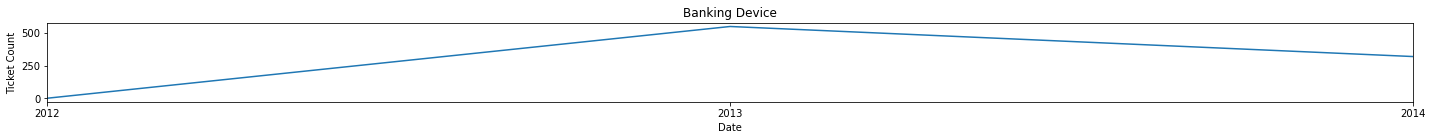

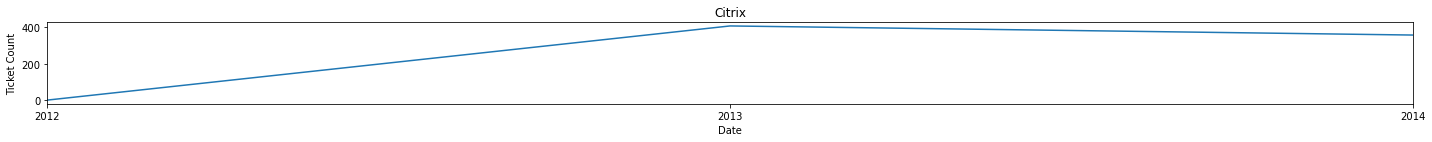

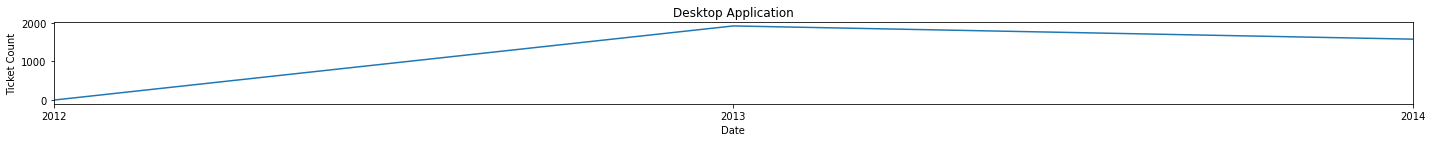

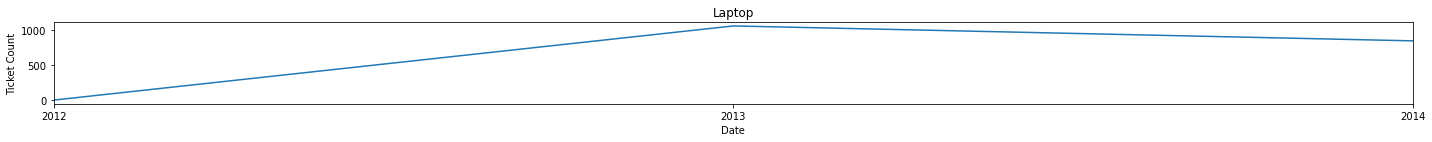

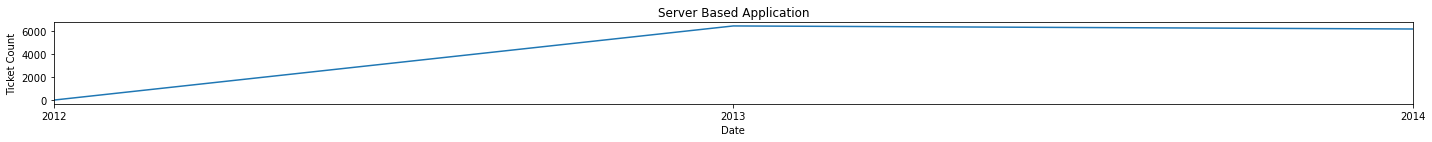

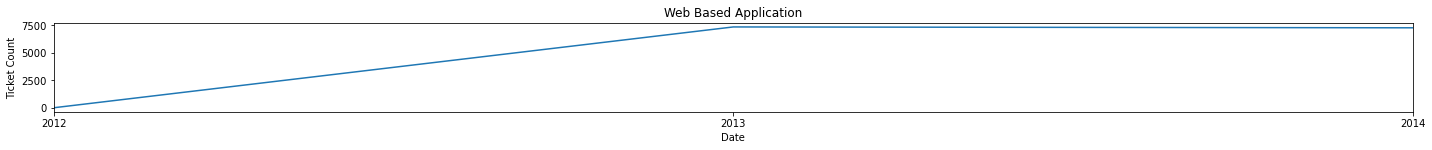

In [41]:
# Plotting all the columns from the annually data
plot_columns(df_annually,6)

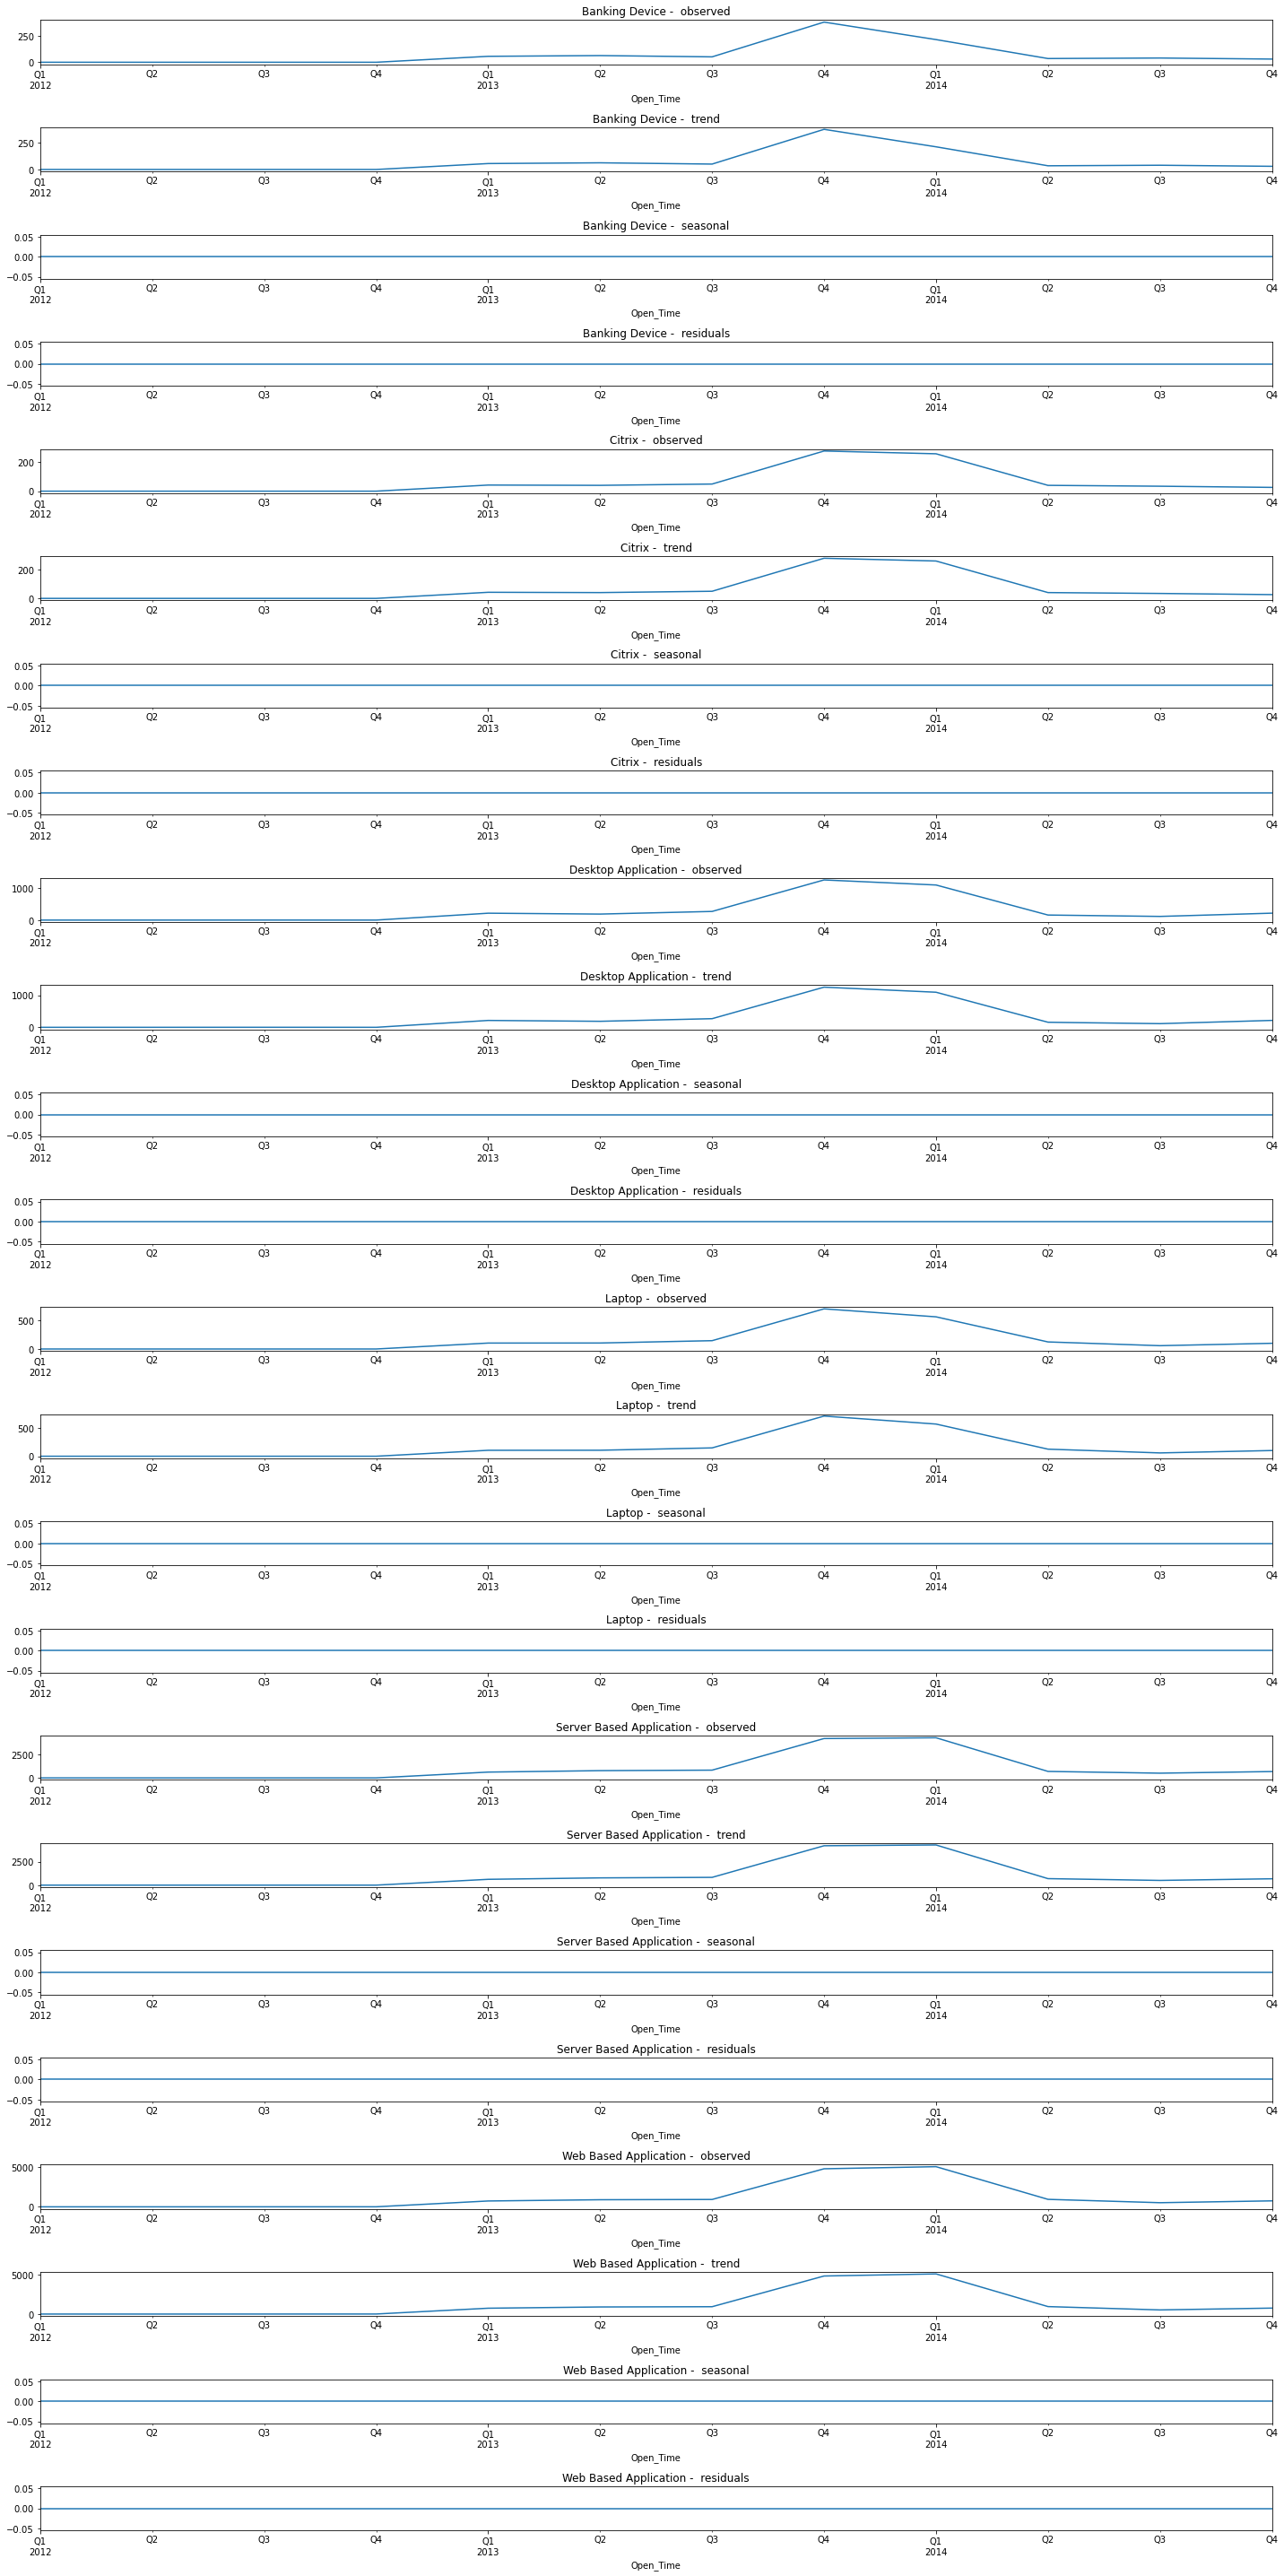

In [42]:
# Seasonal decompose for df_quarterly
decompose_additive(df_quarterly,24)

* Only Horizontal Trend component is present
* we can ensure that data doesn't have seasonality

In [43]:
# Check for stationarity
print("Check stationarity for df_quarterly:")
check_stationarity(df_quarterly)
print("\nSample size is too short to check stationarity for df_annually_updated")

Check stationarity for df_quarterly:
Banking Device - Series is not Stationary
Citrix - Series is not Stationary
Desktop Application - Series is not Stationary
Laptop - Series is not Stationary
Server Based Application - Series is not Stationary
Web Based Application - Series is not Stationary

Sample size is too short to check stationarity for df_annually_updated


In [46]:
df_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-03-31,0.0,0.0,0.0,0.0,0.0,3.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,0.0,1.0,0.0,0.0,5.0
2012-12-31,0.0,0.0,0.0,0.0,1.0,8.0
2013-03-31,56.0,42.0,214.0,104.0,620.0,738.0
2013-06-30,63.0,40.0,187.0,105.0,774.0,895.0
2013-09-30,51.0,49.0,269.0,146.0,828.0,928.0
2013-12-31,379.0,276.0,1250.0,704.0,4197.0,4794.0
2014-03-31,214.0,257.0,1092.0,564.0,4279.0,5059.0


###### Train Test split

In [53]:
df_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-03-31,0.0,0.0,0.0,0.0,0.0,3.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,0.0,1.0,0.0,0.0,5.0
2012-12-31,0.0,0.0,0.0,0.0,1.0,8.0
2013-03-31,56.0,42.0,214.0,104.0,620.0,738.0
2013-06-30,63.0,40.0,187.0,105.0,774.0,895.0
2013-09-30,51.0,49.0,269.0,146.0,828.0,928.0
2013-12-31,379.0,276.0,1250.0,704.0,4197.0,4794.0
2014-03-31,214.0,257.0,1092.0,564.0,4279.0,5059.0


In [54]:
len(df_quarterly)

12

In [55]:
# Split data into train / test sets
train_quarterly = df_quarterly.iloc[:len(df_quarterly)-2]
test_quarterly = df_quarterly.iloc[len(df_quarterly)-2:]

train_annually = df_annually.iloc[:len(df_annually)-1]
test_annually = df_annually.iloc[len(df_annually)-1:]

In [56]:
train_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-03-31,0.0,0.0,0.0,0.0,0.0,3.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,0.0,1.0,0.0,0.0,5.0
2012-12-31,0.0,0.0,0.0,0.0,1.0,8.0
2013-03-31,56.0,42.0,214.0,104.0,620.0,738.0
2013-06-30,63.0,40.0,187.0,105.0,774.0,895.0
2013-09-30,51.0,49.0,269.0,146.0,828.0,928.0
2013-12-31,379.0,276.0,1250.0,704.0,4197.0,4794.0
2014-03-31,214.0,257.0,1092.0,564.0,4279.0,5059.0


In [57]:
test_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2014-09-30,40.0,34.0,114.0,58.0,504.0,522.0
2014-12-31,30.0,26.0,215.0,100.0,678.0,753.0


In [58]:
train_annually

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-12-31,0.0,0.0,1.0,0.0,1.0,18.0
2013-12-31,549.0,407.0,1920.0,1059.0,6419.0,7355.0


In [59]:
test_annually

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2014-12-31,319.0,357.0,1578.0,846.0,6154.0,7277.0


#### Model Creation

#### Forecasting Incident volume quarterly

##### Using ARIMA Model

In [129]:
# Defining function for hypertuning p,d and q value using for loop for ARIMA model
def pdq_hypertuning(column_name):
    p_values = range(2)
    q_values = range(2)
    d_values = range(4)
    for p in p_values:
        for q in q_values:
            for d in d_values:
                model = sm.tsa.arima.ARIMA(train_quarterly[column_name], order=(p,d,q))
                model_arima_fit = model.fit()
                arima_predict = model_arima_fit.forecast(steps=len(test_quarterly))
                print(f"RMSE with {p},{d} and {q}: ",sqrt(mean_squared_error(test_quarterly[column_name],arima_predict)))

In [270]:
# Defining Fit, Forecast and Visualize reusable function
def fit_forecast_visualize(column_name,p,d,q):
    model = sm.tsa.arima.ARIMA(train_quarterly[column_name], order=(p,d,q))
    model_arima_fit = model.fit()
    arima_predict = model_arima_fit.forecast(steps=6)
    plt.rcParams["figure.figsize"] = (20,4)
    plt.plot(arima_predict,color='green')
    plt.plot(df_quarterly[column_name])
    plt.grid()
    plt.legend(['Forecasted','Actual'])
    print(f"RMSE for {column_name} : ",sqrt(mean_squared_error(test_quarterly[column_name],arima_predict[:len(test_quarterly)])))
    Date = pd.date_range(start="2014-09-30",periods=6,freq='Q')
    Forecast = pd.DataFrame(zip(arima_predict),index=Date,columns=['Forecasted_Incident_counts'])
    print("\n\n",Forecast)

###### Forecasting Incident count quarterly for Web Based Application

In [271]:
# Hypertuning p,q and d
pdq_hypertuning('Web Based Application')

RMSE with 0,0 and 0:  709.4647630432395
RMSE with 0,1 and 0:  326.60450088754135
RMSE with 0,2 and 0:  6258.066354713729
RMSE with 0,3 and 0:  16031.625011208307
RMSE with 0,0 and 1:  324.82873856060803
RMSE with 0,1 and 1:  1124.3739450096282
RMSE with 0,2 and 1:  7689.371077227076
RMSE with 0,3 and 1:  7111.4754430281255
RMSE with 1,0 and 0:  567.7125128052403
RMSE with 1,1 and 0:  283.77551935848027
RMSE with 1,2 and 0:  6534.672038580547
RMSE with 1,3 and 0:  15533.27920104372
RMSE with 1,0 and 1:  319.9029735485067
RMSE with 1,1 and 1:  545.3550525718092
RMSE with 1,2 and 1:  108.8123418418374
RMSE with 1,3 and 1:  7741.47106451615


RMSE for Web Based Application :  108.8123418418374


             Forecasted_Incident_counts
2014-09-30                  615.888410
2014-12-31                  631.077000
2015-03-31                  677.190072
2015-06-30                  726.096961
2015-09-30                  775.256251
2015-12-31                  824.438344


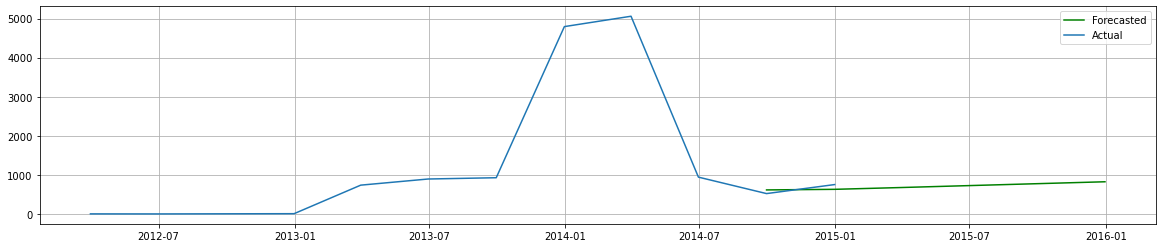

In [272]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Web Based Application',1,2,1) #column_name,p,d,q

###### Forecasting Incident count quarterly for Server Based Application

In [273]:
# Hypertuning p,q and d
pdq_hypertuning('Server Based Application')

RMSE with 0,0 and 0:  555.0572256815719
RMSE with 0,1 and 0:  134.06341782902632
RMSE with 0,2 and 0:  5601.886200200783
RMSE with 0,3 and 0:  13779.262425833973
RMSE with 0,0 and 1:  262.7875942127714
RMSE with 0,1 and 1:  1116.7667457218758
RMSE with 0,2 and 1:  207.75515769902762
RMSE with 0,3 and 1:  6349.238853230693
RMSE with 1,0 and 0:  399.40562067542163
RMSE with 1,1 and 0:  91.13521377782327
RMSE with 1,2 and 0:  5750.902253894052
RMSE with 1,3 and 0:  13516.188243792445
RMSE with 1,0 and 1:  246.54011552121344
RMSE with 1,1 and 1:  527.6319367196949
RMSE with 1,2 and 1:  333.29221913542733
RMSE with 1,3 and 1:  6768.588091633417


RMSE for Server Based Application :  134.06341782902632


             Forecasted_Incident_counts
2014-09-30                       693.0
2014-12-31                       693.0
2015-03-31                       693.0
2015-06-30                       693.0
2015-09-30                       693.0
2015-12-31                       693.0


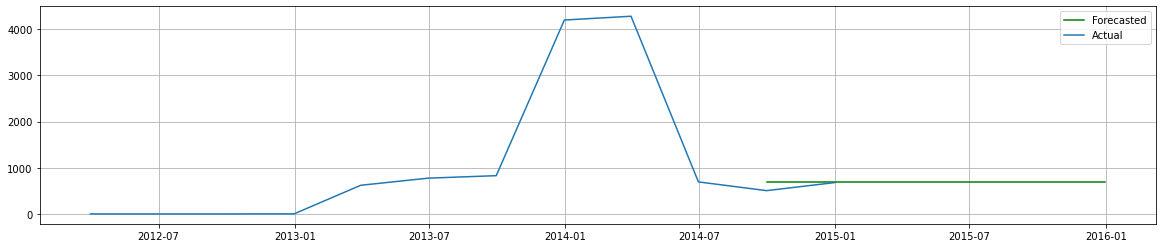

In [274]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Server Based Application',0,1,0) #column_name,p,d,q

###### Forecasting Incident count quarterly for Laptop

In [275]:
# Hypertuning p,q and d
pdq_hypertuning('Laptop')

RMSE with 0,0 and 0:  97.97713928637684
RMSE with 0,1 and 0:  49.658836071740545
RMSE with 0,2 and 0:  660.5346319459717
RMSE with 0,3 and 0:  1330.0022556371835
RMSE with 0,0 and 1:  81.49134449186855
RMSE with 0,1 and 1:  77.87481863451193
RMSE with 0,2 and 1:  66.81461736329742
RMSE with 0,3 and 1:  775.0400066494061
RMSE with 1,0 and 0:  68.32583689828502
RMSE with 1,1 and 0:  43.25143575495195
RMSE with 1,2 and 0:  586.7725659690396
RMSE with 1,3 and 0:  1734.0486432935047
RMSE with 1,0 and 1:  76.25939934089195
RMSE with 1,1 and 1:  65.6942984192465
RMSE with 1,2 and 1:  45.28788089502357
RMSE with 1,3 and 1:  732.8354403442523


RMSE for Laptop :  49.658836071740545


             Forecasted_Incident_counts
2014-09-30                       124.0
2014-12-31                       124.0
2015-03-31                       124.0
2015-06-30                       124.0
2015-09-30                       124.0
2015-12-31                       124.0


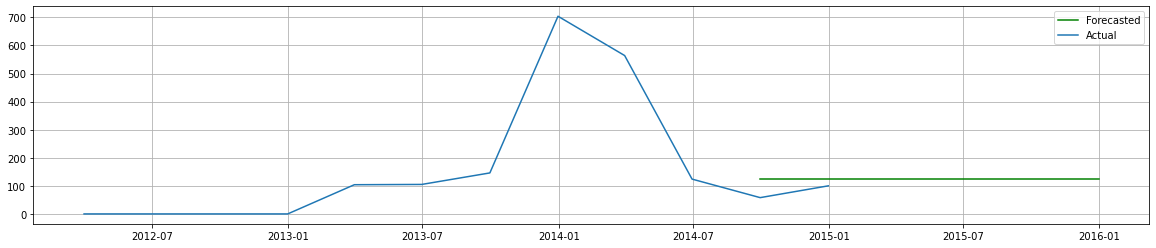

In [276]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Laptop',0,1,0) #column_name,p,d,q

###### Forecasting Incident count quarterly for Desktop Application

In [277]:
# Hypertuning p,q and d
pdq_hypertuning('Desktop Application')

RMSE with 0,0 and 0:  160.644102008023
RMSE with 0,1 and 0:  51.05389309347523
RMSE with 0,2 and 0:  1502.1398070752261
RMSE with 0,3 and 0:  3234.5511280547134
RMSE with 0,0 and 1:  57.46232498553145
RMSE with 0,1 and 1:  242.19890441975167
RMSE with 0,2 and 1:  45.64861346432185
RMSE with 0,3 and 1:  1726.5390220706229
RMSE with 1,0 and 0:  83.3400022271932
RMSE with 1,1 and 0:  78.38627094507527
RMSE with 1,2 and 0:  1443.341525953737
RMSE with 1,3 and 0:  3537.7404374840557
RMSE with 1,0 and 1:  35.266282827337605
RMSE with 1,1 and 1:  102.33857683468113
RMSE with 1,2 and 1:  292.5045709825667
RMSE with 1,3 and 1:  1742.8780460886178


RMSE for Desktop Application :  35.266282827337605


             Forecasted_Incident_counts
2014-09-30                  126.556509
2014-12-31                  263.267541
2015-03-31                  278.342518
2015-06-30                  280.004819
2015-09-30                  280.188119
2015-12-31                  280.208332


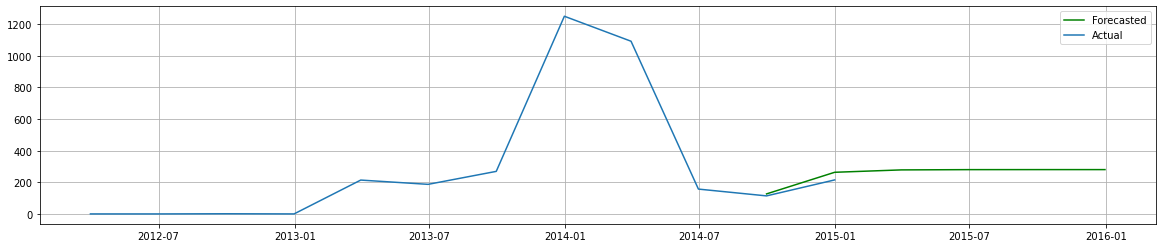

In [278]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Desktop Application',1,0,1) #column_name,p,d,q

###### Forecasting Incident count quarterly for Citrix

In [279]:
# Hypertuning p,q and d
pdq_hypertuning('Citrix')

RMSE with 0,0 and 0:  40.59753349608054
RMSE with 0,1 and 0:  10.770329614269007
RMSE with 0,2 and 0:  332.3559838486456
RMSE with 0,3 and 0:  773.1354991203024
RMSE with 0,0 and 1:  26.53310727612257
RMSE with 0,1 and 1:  58.31607404143229
RMSE with 0,2 and 1:  17.739007480820767
RMSE with 0,3 and 1:  391.91039586797416
RMSE with 1,0 and 0:  26.503407202536657
RMSE with 1,1 and 0:  5.640568173704609
RMSE with 1,2 and 0:  320.84965998199317
RMSE with 1,3 and 0:  809.2894195335249
RMSE with 1,0 and 1:  23.882948180988475
RMSE with 1,1 and 1:  13.754187211686013
RMSE with 1,2 and 1:  56.80861119146187
RMSE with 1,3 and 1:  422.78966926112224


RMSE for Citrix :  10.770329614269007


             Forecasted_Incident_counts
2014-09-30                        40.0
2014-12-31                        40.0
2015-03-31                        40.0
2015-06-30                        40.0
2015-09-30                        40.0
2015-12-31                        40.0


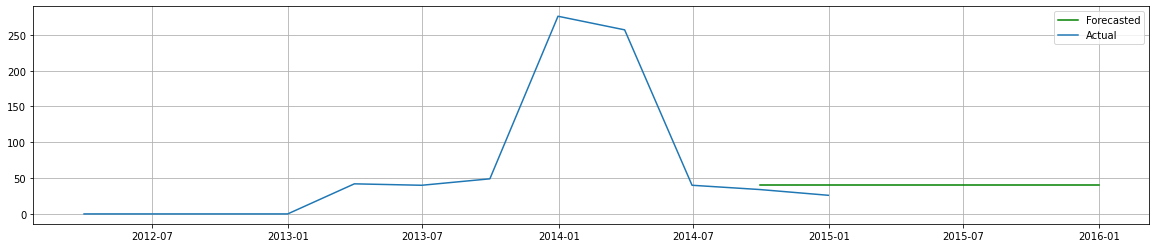

In [280]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Citrix',0,1,0) #column_name,p,d,q

###### Forecasting Incident count quarterly for Banking Device

In [281]:
# Hypertuning p,q and d
pdq_hypertuning('Banking Device')

RMSE with 0,0 and 0:  45.078150447674744
RMSE with 0,1 and 0:  5.0
RMSE with 0,2 and 0:  281.48268152765627
RMSE with 0,3 and 0:  312.43319285889396
RMSE with 0,0 and 1:  34.94688936198787
RMSE with 0,1 and 1:  93.17918481704363
RMSE with 0,2 and 1:  9.029672794244524
RMSE with 0,3 and 1:  329.33812182972565
RMSE with 1,0 and 0:  31.640066904744085
RMSE with 1,1 and 0:  29.404114256570256
RMSE with 1,2 and 0:  273.791733972669
RMSE with 1,3 and 0:  928.5299196574397
RMSE with 1,0 and 1:  43.20669440153437
RMSE with 1,1 and 1:  24.656366905638137
RMSE with 1,2 and 1:  23.308924559850563
RMSE with 1,3 and 1:  336.95835978007267


RMSE for Banking Device :  5.0


             Forecasted_Incident_counts
2014-09-30                        35.0
2014-12-31                        35.0
2015-03-31                        35.0
2015-06-30                        35.0
2015-09-30                        35.0
2015-12-31                        35.0


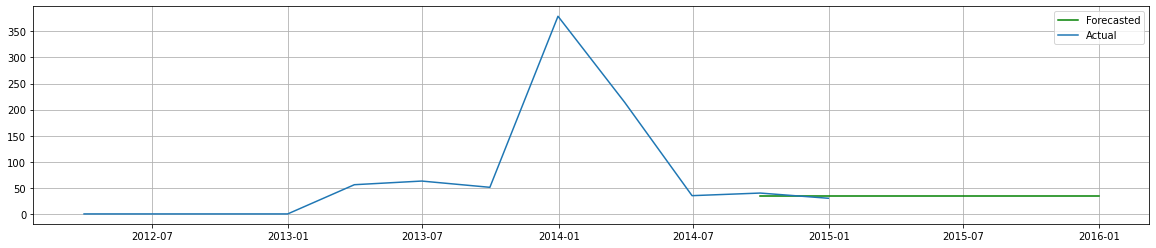

In [282]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Banking Device',0,1,0) #column_name,p,d,q

##### Using Long Short Term Memory (LSTM) Networks

In [283]:
# Scaling the data using Minmax scaler
scaler1 = MinMaxScaler()
scaler1.fit(train_quarterly)
scaled_train = scaler1.transform(train_quarterly)
scaled_test = scaler1.transform(test_quarterly)

In [284]:
length = 1 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [285]:
len(scaled_train), len(scaled_test)

(10, 2)

In [286]:
# Checking the first batch to check whether data is generated fine
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.         0.         0.         0.         0.00019775]
Predict this y: 
 [[0. 0. 0. 0. 0. 0.]]


In [288]:
scaled_train.shape

(10, 6)

In [289]:
# define model
model = Sequential()
# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))
# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               42800     
                                                                 
 dense_8 (Dense)             (None, 6)                 606       
                                                                 
Total params: 43,406
Trainable params: 43,406
Non-trainable params: 0
_________________________________________________________________


In [290]:
# Used early stopping
early_stop = EarlyStopping(monitor='loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

model.fit_generator(generator,epochs=200,callbacks=[early_stop],verbose=False)

In [291]:
model.history.history.keys()

dict_keys(['loss'])

<AxesSubplot:>

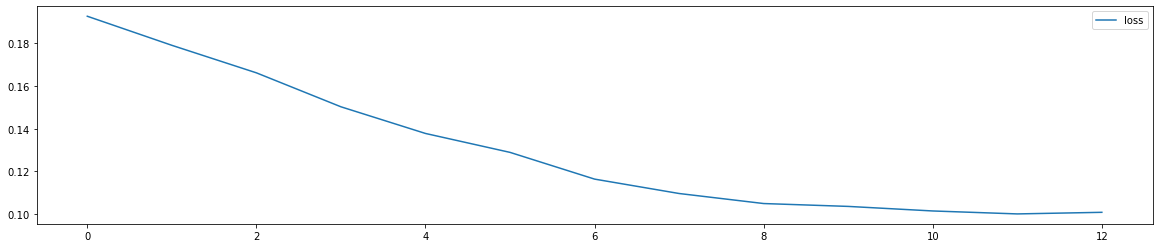

In [292]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [293]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_quarterly)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


In [294]:
test_predictions

[array([0.16739552, 0.19916762, 0.2005022 , 0.19233462, 0.21183556,
        0.217635  ], dtype=float32),
 array([0.18666826, 0.22198562, 0.22541623, 0.21918261, 0.24058673,
        0.24547896], dtype=float32)]

In [295]:
scaled_test

array([[0.1055409 , 0.12318841, 0.0912    , 0.08238636, 0.11778453,
        0.10282776],
       [0.07915567, 0.0942029 , 0.172     , 0.14204545, 0.15844824,
        0.14850702]])

In [296]:
true_predictions = scaler1.inverse_transform(test_predictions)
true_predictions

array([[  63.44290103,   54.97026426,  250.62775239,  135.40357399,
         906.44437486, 1102.58022389],
       [  70.74727125,   61.26803201,  281.77028522,  154.3045578 ,
        1029.4706085 , 1243.38709006]])

In [297]:
test_quarterly

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2014-09-30,40.0,34.0,114.0,58.0,504.0,522.0
2014-12-31,30.0,26.0,215.0,100.0,678.0,753.0


In [298]:
# Model Evaluation
for cols,i in zip(df_quarterly.columns,range(len(df_quarterly.columns))): 
    print(f"RMSE for {cols} : ",sqrt(mean_squared_error(test_quarterly[cols],true_predictions[:,i])))

RMSE for Banking Device :  33.24086132617266
RMSE for Citrix :  29.013669753524095
RMSE for Desktop Application :  107.53002769532723
RMSE for Laptop :  66.85917388171333
RMSE for Server Based Application :  377.81811993148625
RMSE for Web Based Application :  537.3792396737747


LSTM model is not better than ARIMA model

#### ARIMA Model performs better to forecast the incidents quarterly with respect to CI_Subcat

* RMSE for Web Based Application :  108.81
* RMSE for Server Based Application :  134.06
* RMSE for Laptop :  49.66
* RMSE for Desktop Application :  35.27
* RMSE for Citrix :  10.77
* RMSE for Banking Device :  5.0

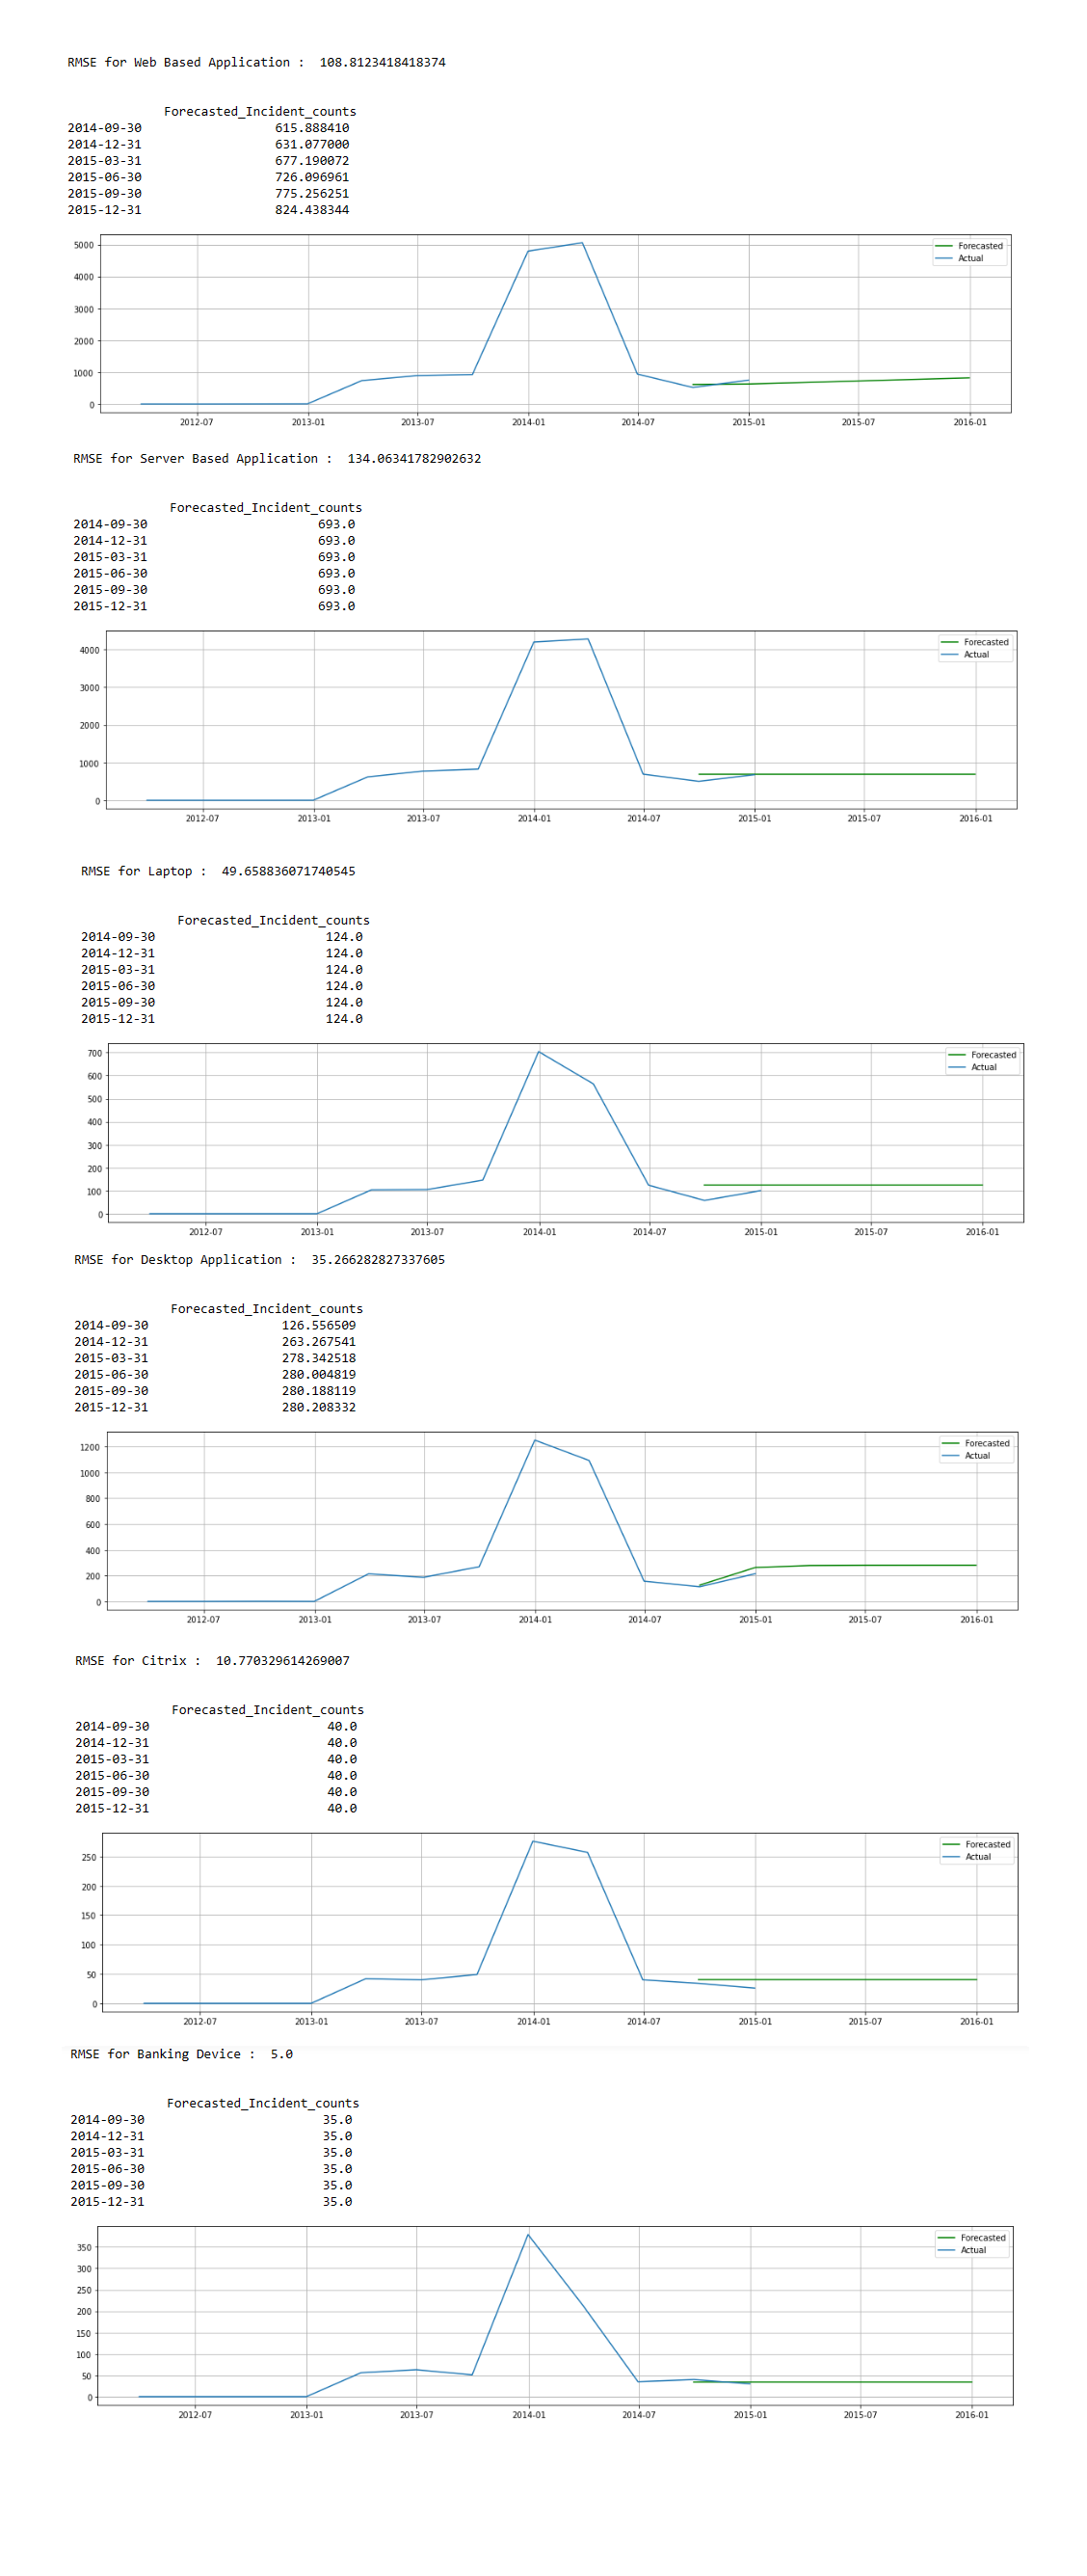

#### Forecasting Incident volume annually

###### Using ARIMA

In [418]:
# Defining function for hypertuning p,d and q value using for loop for ARIMA model
def pdq_hypertuning(column_name):
    d_values = range(2)
    for d in d_values:
        model = sm.tsa.arima.ARIMA(train_annually[column_name], order=(0,d,0))
        model_arima_fit = model.fit()
        arima_predict = model_arima_fit.forecast(steps=len(test_annually))
        print(f"RMSE with 0,{d} and 0: ",sqrt(mean_squared_error(test_annually[column_name],arima_predict)))

In [419]:
# Defining Fit, Forecast and Visualize reusable function
def fit_forecast_visualize(column_name,p,d,q):
    model = sm.tsa.arima.ARIMA(train_annually[column_name], order=(p,d,q))
    model_arima_fit = model.fit()
    arima_predict = model_arima_fit.forecast(steps=3)
    plt.rcParams["figure.figsize"] = (20,4)
    plt.plot(df_annually[column_name])
    plt.grid()
    plt.legend(['Forecasted','Actual'])
    print(f"RMSE for {column_name} : ",sqrt(mean_squared_error(test_annually[column_name],arima_predict[:len(test_annually)])))
    Date = pd.date_range(start="2014-12-31",periods=3,freq='A')
    Forecast = pd.DataFrame(zip(arima_predict),index=Date,columns=['Forecasted_Incident_counts'])
    print("\n\n",Forecast)
    plt.plot(Forecast, color='green')
    plt.legend(["Actual","Forecasted"])

In [420]:
train_annually

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2012-12-31,0.0,0.0,1.0,0.0,1.0,18.0
2013-12-31,549.0,407.0,1920.0,1059.0,6419.0,7355.0


In [421]:
test_annually

CI_Subcat,Banking Device,Citrix,Desktop Application,Laptop,Server Based Application,Web Based Application
Open_Time,,,,,,
2014-12-31,319.0,357.0,1578.0,846.0,6154.0,7277.0


In [422]:
test_annually.columns

Index(['Banking Device', 'Citrix', 'Desktop Application', 'Laptop',
       'Server Based Application', 'Web Based Application'],
      dtype='object', name='CI_Subcat')

###### Forecasting Incident count annually for Web Based Application

In [423]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Web Based Application')

RMSE with 0,0 and 0:  3590.500000000001
RMSE with 0,1 and 0:  78.0


RMSE for Web Based Application :  78.0


             Forecasted_Incident_counts
2014-12-31                      7355.0
2015-12-31                      7355.0
2016-12-31                      7355.0


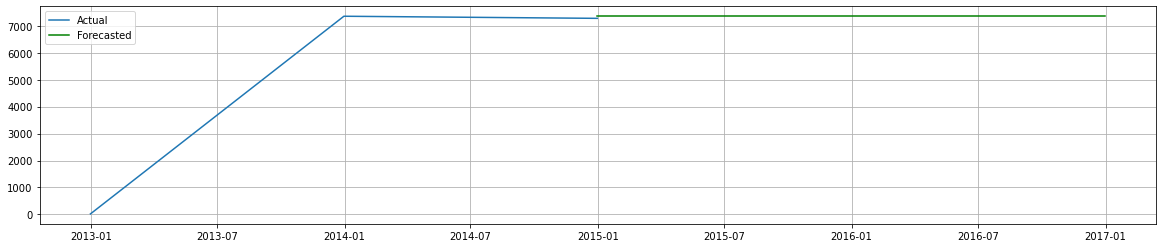

In [424]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Web Based Application',0,1,0) #column_name,p,d,q

###### Forecasting Incident count annually for Server Based Application

In [425]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Server Based Application')

RMSE with 0,0 and 0:  2943.99273753342
RMSE with 0,1 and 0:  265.0


RMSE for Server Based Application :  265.0


             Forecasted_Incident_counts
2014-12-31                      6419.0
2015-12-31                      6419.0
2016-12-31                      6419.0


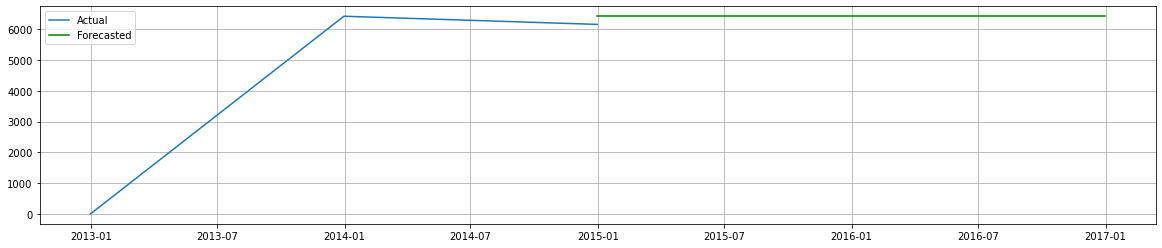

In [426]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Server Based Application',0,1,0) #column_name,p,d,q

###### Forecasting Incident count annually for Laptop

In [427]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Laptop')

RMSE with 0,0 and 0:  316.5000066724772
RMSE with 0,1 and 0:  213.0


RMSE for Laptop :  213.0


             Forecasted_Incident_counts
2014-12-31                      1059.0
2015-12-31                      1059.0
2016-12-31                      1059.0


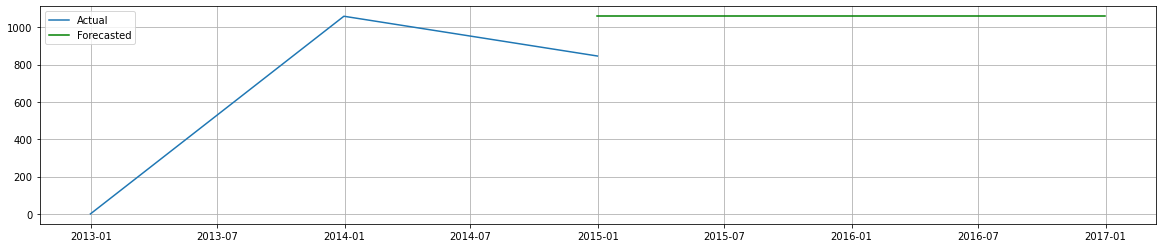

In [428]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Laptop',0,1,0) #column_name,p,d,q

###### Forecasting Incident count annually for Desktop Application

In [429]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Desktop Application')

RMSE with 0,0 and 0:  617.5000000000002
RMSE with 0,1 and 0:  341.9999999999998


RMSE for Desktop Application :  341.9999999999998


             Forecasted_Incident_counts
2014-12-31                      1920.0
2015-12-31                      1920.0
2016-12-31                      1920.0


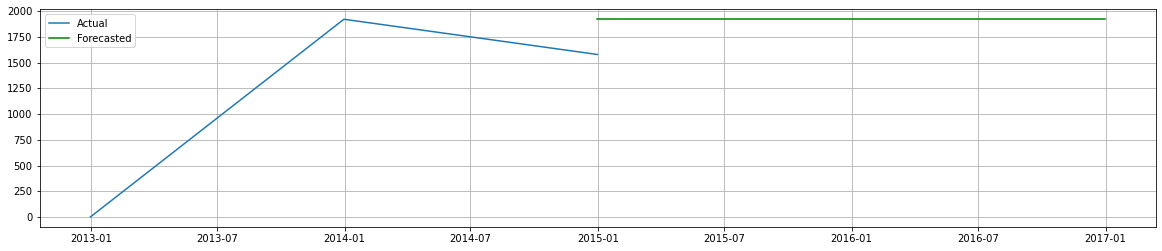

In [430]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Desktop Application',0,1,0) #column_name,p,d,q

###### Forecasting Incident count annually for Citrix

In [431]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Citrix')

RMSE with 0,0 and 0:  153.50000357540802
RMSE with 0,1 and 0:  50.0


RMSE for Citrix :  50.0


             Forecasted_Incident_counts
2014-12-31                       407.0
2015-12-31                       407.0
2016-12-31                       407.0


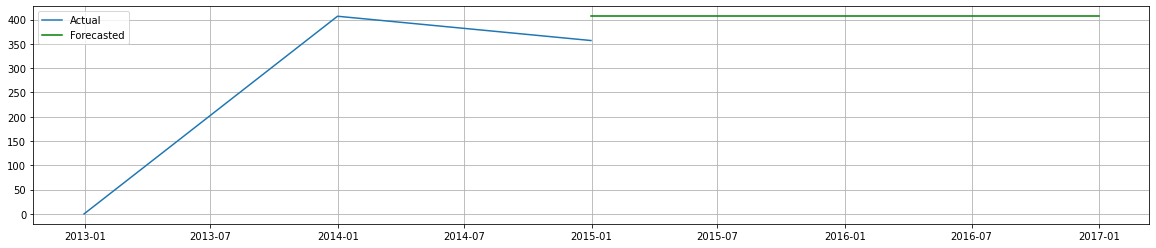

In [432]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Citrix',0,1,0) #column_name,p,d,q

###### Forecasting Incident count annually for Banking Device

In [433]:
# Hypertuning d with 0 and 1
pdq_hypertuning('Banking Device')

RMSE with 0,0 and 0:  44.50000754492282
RMSE with 0,1 and 0:  230.0


RMSE for Banking Device :  44.50000754492282


             Forecasted_Incident_counts
2014-12-31                  274.499992
2015-12-31                  274.499992
2016-12-31                  274.499992


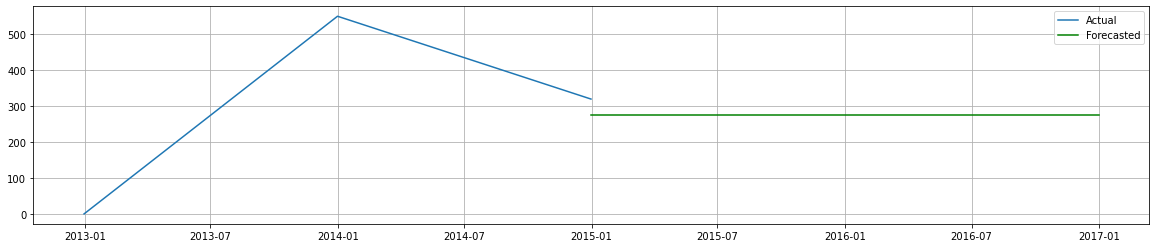

In [434]:
# Fit, Forecast and Visualize using best parameters found by hyperparameter tuning
fit_forecast_visualize('Banking Device',0,0,0) #column_name,p,d,q

### Business case 3: Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced.

In [49]:
itsm_dataset.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

In [50]:
# Extracting required data
df = itsm_dataset[itsm_dataset.columns[0:11]].drop(['Incident_ID','Status','number_cnt'],axis=1)

In [51]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
0,SUB000508,subapplication,Web Based Application,WBS000162,4,4,4,incident
1,WBA000124,application,Web Based Application,WBS000088,3,3,3,incident
2,DTA000024,application,Desktop Application,WBS000092,NS,3,NA,request for information
3,WBA000124,application,Web Based Application,WBS000088,4,4,4,incident
4,WBA000124,application,Web Based Application,WBS000088,4,4,4,incident


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CI_Name    46606 non-null  object
 1   CI_Cat     46606 non-null  object
 2   CI_Subcat  46606 non-null  object
 3   WBS        46606 non-null  object
 4   Impact     46606 non-null  object
 5   Urgency    46606 non-null  object
 6   Priority   46606 non-null  object
 7   Category   46606 non-null  object
dtypes: object(8)
memory usage: 2.8+ MB


In [53]:
df.shape

(46606, 8)

In [54]:
df.describe()

,CI_Name,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
count,46606,46606,46606,46606,46606,46606,46606,46606
unique,3019,13,65,274,6,6,6,4
top,SUB000456,application,Server Based Application,WBS000073,4,4,4,incident
freq,3050,32900,18811,13342,22556,22588,22717,37748


###### Data Preprocessing  

In [55]:
# Check missing values
df.isnull().sum()

CI_Name      0
CI_Cat       0
CI_Subcat    0
WBS          0
Impact       0
Urgency      0
Priority     0
Category     0
dtype: int64

No missing values

In [56]:
# Check for corrupted values if any.
df.Urgency.value_counts()

4               22588
5               16779
3                6536
2                 696
1                   6
5 - Very Low        1
Name: Urgency, dtype: int64

In [57]:
# Check for corrupted values if any.
df.Impact.value_counts()

4     22556
5     16741
3      5234
NS     1380
2       692
1         3
Name: Impact, dtype: int64

NS - Not specified. There are 1380 tickets mentioned as NS

In [58]:
# Check for corrupted values if any.
df.Priority.value_counts()

4     22717
5     16486
3      5323
NA     1380
2       697
1         3
Name: Priority, dtype: int64

NA - Not Applicable. There are 1380 tickets mentioned as NA

In [91]:
# Checking whether rows dont have both Impact and Priority information
df.query('Impact == "NS" & Priority == "NA"')

,CI_Name,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
2,DTA000024,application,Desktop Application,WBS000092,NS,3,NA,request for information
8,WBA000124,application,Web Based Application,WBS000088,NS,3,NA,incident
103,SBA000782,application,Server Based Application,WBS000043,NS,3,NA,incident
147,SBA000782,application,Server Based Application,WBS000043,NS,3,NA,incident
152,SBA000782,application,Server Based Application,WBS000043,NS,3,NA,incident
...,...,...,...,...,...,...,...,...
46424,SBA000172,application,Server Based Application,WBS000014,NS,3,NA,incident
46446,ADB000010,database,Database,WBS000239,NS,3,NA,incident
46484,SBA000759,application,Server Based Application,WBS000296,NS,3,NA,incident
46553,CNT000046,storage,Controller,WBS000183,NS,3,NA,incident


In [92]:
df.query('Impact == "NS" & Priority == "NA"').Urgency.value_counts()

3    1348
4      32
Name: Urgency, dtype: int64

We dont have values updated for only tickets which have 3 and 4 as Urgency

In [93]:
# Update Impact value 'NS' with mode
df['Impact'] = df['Impact'].replace('NS', df.Impact.mode()[0])

In [94]:
df.Impact.value_counts()

4    23936
5    16741
3     5234
2      692
1        3
Name: Impact, dtype: int64

In [95]:
# Impact 'NS' value is updated with mode value '5', when checking priority matrix the priority is 4
# Update 'NA' Priority using Priority matrix 
df['Priority'] = df['Priority'].replace('NA', '4')

In [96]:
df.Priority.value_counts()

4    24097
5    16486
3     5323
2      697
1        3
Name: Priority, dtype: int64

If the user didnt mention the impact and if the urgency is 3, then we should consider the ticket with low priority 

In [97]:
# Checking for corrupted values in CI_cat and CI_Subcat column
df.query("CI_Cat == '' | CI_Subcat == ''")

,CI_Name,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
316,OVR000033,,,WBS000118,5,5,5,incident
538,OVR000078,,,WBS000187,3,3,3,incident
593,OVR000072,,,WBS000187,3,3,3,incident
670,OVR000099,,,WBS000135,5,5,5,request for information
1128,OVR000033,,,WBS000118,2,2,2,incident
...,...,...,...,...,...,...,...,...
34462,OVR000033,,,WBS000118,4,4,4,incident
34868,OVR000033,,,WBS000118,5,5,5,incident
36150,OVR000033,,,WBS000118,3,3,3,incident
38262,OVR000033,,,WBS000118,5,5,5,incident


CI_Name which starts with OVR, have empty CI_Cat and CI_Subcat values

In [98]:
# Replacing those empty entries with OVR for both CI_Cat and CI_Subcat columns
df['CI_Cat'] = df['CI_Cat'].replace('', 'OVR')
df['CI_Subcat'] = df['CI_Subcat'].replace('', 'OVR')

In [99]:
# Ensuring there are no empty values in both CI_Cat and CI_Subcat
df.query("CI_Cat == '' | CI_Subcat == ''")

,CI_Name,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category


In [100]:
# Remove unwanted columns
df = df.drop('CI_Name',axis=1)

In [101]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [102]:
# Ensure there is no duplicate rows
df[df.duplicated()]

,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category


In [103]:
df.shape

(1509, 7)

In [104]:
df.head()

,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
0,subapplication,Web Based Application,WBS000162,4,4,4,incident
1,application,Web Based Application,WBS000088,3,3,3,incident
2,application,Desktop Application,WBS000092,4,3,4,request for information
3,application,Web Based Application,WBS000088,4,4,4,incident
6,application,Web Based Application,WBS000055,4,4,4,incident


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 46548
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CI_Cat     1509 non-null   object
 1   CI_Subcat  1509 non-null   object
 2   WBS        1509 non-null   object
 3   Impact     1509 non-null   object
 4   Urgency    1509 non-null   object
 5   Priority   1509 non-null   object
 6   Category   1509 non-null   object
dtypes: object(7)
memory usage: 94.3+ KB


In [112]:
df.Priority.value_counts()

4    648
3    380
5    368
2    110
1      3
Name: Priority, dtype: int64

In [114]:
# Converting Categorical into Numerical
le=LabelEncoder()
df['CI_Subcat'] = le.fit_transform(df['CI_Subcat'])
le1=LabelEncoder()
df['Priority'] = le1.fit_transform(df['Priority'])

In [115]:
df.Priority.value_counts()

3    648
2    380
4    368
1    110
0      3
Name: Priority, dtype: int64

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 46548
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CI_Cat     1509 non-null   object
 1   CI_Subcat  1509 non-null   int32 
 2   WBS        1509 non-null   object
 3   Impact     1509 non-null   object
 4   Urgency    1509 non-null   object
 5   Priority   1509 non-null   int32 
 6   Category   1509 non-null   object
dtypes: int32(2), object(5)
memory usage: 82.5+ KB


In [117]:
df.head()

,CI_Cat,CI_Subcat,WBS,Impact,Urgency,Priority,Category
0,subapplication,58,WBS000162,4,4,3,incident
1,application,58,WBS000088,3,3,2,incident
2,application,10,WBS000092,4,3,3,request for information
3,application,58,WBS000088,4,4,3,incident
6,application,58,WBS000055,4,4,3,incident


###### Adding features and labels

In [118]:
df.columns

Index(['CI_Cat', 'CI_Subcat', 'WBS', 'Impact', 'Urgency', 'Priority',
       'Category'],
      dtype='object')

In [119]:
# Handling Categorical data using Column Transformer
cols_for_cv = ['CI_Cat', 'WBS','Category']
cols_trans = ColumnTransformer([
    ('cv_ci_cat', CountVectorizer(), 'CI_Cat'),
    ('cv_wbs', CountVectorizer(), 'WBS'),
    ('cv_category', CountVectorizer(), 'Category'),
    ('ohe_impact_urgency', OneHotEncoder(handle_unknown = 'ignore'), ['Impact','Urgency'])])  

In [120]:
cols_trans

ColumnTransformer(transformers=[('cv_ci_cat', CountVectorizer(), 'CI_Cat'),
                                ('cv_wbs', CountVectorizer(), 'WBS'),
                                ('cv_category', CountVectorizer(), 'Category'),
                                ('ohe_impact_urgency',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Impact', 'Urgency'])])

In [121]:
# Independent and dependent variable creation
X = df[['CI_Cat','WBS', 'Impact', 'Urgency','Category']]
y = df[['Priority','CI_Subcat']]

###### Train and Test split

In [122]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y[['Priority']])

In [123]:
X_train.shape

(1207, 5)

In [124]:
X_test.shape

(302, 5)

In [125]:
y_train.shape

(1207, 2)

In [126]:
y_test.shape

(302, 2)

In [127]:
X_train.Urgency.value_counts()

3               457
4               337
5               320
2                86
1                 6
5 - Very Low      1
Name: Urgency, dtype: int64

In [128]:
y_train.Priority.value_counts()

3    518
2    304
4    294
1     88
0      3
Name: Priority, dtype: int64

In [129]:
y_test.Priority.value_counts()

3    130
2     76
4     74
1     22
Name: Priority, dtype: int64

In [130]:
X_train.head(10)

,CI_Cat,WBS,Impact,Urgency,Category
4037,hardware,WBS000166,4,3,incident
18637,database,WBS000239,4,3,incident
12318,OVR,WBS000002,4,4,incident
1978,application,WBS000165,5,5,incident
14086,application,WBS000249,3,3,incident
434,application,WBS000054,5,5,request for information
690,application,WBS000217,3,3,incident
11487,application,WBS000007,3,3,incident
2593,application,WBS000163,4,3,incident
33368,networkcomponents,WBS000254,5,5,request for information


In [131]:
y_train.head(10)

,Priority,CI_Subcat
4037,3,6
18637,3,7
12318,3,35
1978,4,46
14086,2,46
434,4,46
690,2,10
11487,2,46
2593,3,46
33368,4,30


In [132]:
y_test

,Priority,CI_Subcat
16994,3,46
26401,3,58
5813,3,58
2209,3,5
1424,4,25
...,...,...
22041,4,46
37627,3,46
21472,2,50
974,2,7


##### Model Creation

In [134]:
# Defining a function to predict Xtest and check the model performance metrics
def performance_metrics(model):
    print("Train score : " , model.score(X_train, y_train))
    print("Test score : " , model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print("Prediction Accuracy - Priority : " ,accuracy_score(y_test[y_test.columns[0]], y_pred[:,0]))
    print("Prediction Accuracy - Department : " ,accuracy_score(y_test[y_test.columns[1]], y_pred[:,1]))

In [135]:
# Using KFold cross validation technique as this is a classification problem
kfold=KFold(5)

###### Using Logistic Regression

In [253]:
# Creating multioutput classifier model using Logistic Regression
pipe_lr = Pipeline(steps=[('trans', cols_trans),
                          ('lr_multi',MultiOutputClassifier(LogisticRegression(random_state=41)))])
pipe_lr.fit(X_train,y_train)
performance_metrics(pipe_lr)

Train score :  0.8111019055509527
Test score :  0.7317880794701986
Prediction Accuracy - Priority :  0.9834437086092715
Prediction Accuracy - Department :  0.7417218543046358


We got good score predicting Priority, hence we will hypertune for Department alone

In [254]:
# Creating model and hyperparameter tuning using Randomizedsearchcv
pipe_lr = Pipeline(steps=[('trans', cols_trans),
                          ('lr',LogisticRegression(random_state=41))])
#setting parameters
parameter = {
    'lr__max_iter' : [50, 100, 200, 400, 500, 600],
    'lr__solver' :['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'lr__C': [0.0001,0.001,0.01,1,10,100,1000]
}

logistic = RandomizedSearchCV(estimator=pipe_lr,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
logistic.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',logistic.best_score_)
print('Best parameters : ',logistic.best_params_)

Best score of Accuracy :  0.7804773498851205
Best parameters :  {'lr__solver': 'liblinear', 'lr__max_iter': 100, 'lr__C': 10}


In [255]:
# Logistic Regression CV results
pd.DataFrame(logistic.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__solver,param_lr__max_iter,param_lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,0.224983,0.007657,0.018751,0.006251,liblinear,100,10,"{'lr__solver': 'liblinear', 'lr__max_iter': 10...",0.77686,0.747934,0.784232,0.80083,0.792531,0.780477,0.018143,1,0.907772,0.907772,0.899586,0.901656,0.904762,0.90431,0.003272


In [75]:
# Using best Hyperparameter
pipe_lr_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('lr_multi',MultiOutputClassifier(LogisticRegression(random_state=42,
                                                                               solver='liblinear',
                                                                              max_iter=100,C=10)))])
pipe_lr_hyper.fit(X_train,y_train)
performance_metrics(pipe_lr_hyper)

Train score :  0.8666114333057167
Test score :  0.7682119205298014
Prediction Accuracy - Priority :  0.9701986754966887
Prediction Accuracy - Department :  0.7947019867549668


###### Using Naive Bayes Classifier

In [204]:
# Creating multioutput classifier model using Naive Bayes Classifier
pipe_nb = Pipeline(steps=[('trans', cols_trans),
                          ('nb_multi',MultiOutputClassifier(MultinomialNB()))])
pipe_nb.fit(X_train,y_train)
performance_metrics(pipe_nb)

Train score :  0.6793703396851698
Test score :  0.6324503311258278
Prediction Accuracy - Priority :  0.9834437086092715
Prediction Accuracy - Department :  0.6357615894039735


We got good score predicting Priority, hence we will hypertune for Department alone

In [258]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_nb = Pipeline(steps=[('trans', cols_trans),
                          ('nb',MultinomialNB())])
#setting parameters
parameter = {
    'nb__alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
}

naive = RandomizedSearchCV(estimator=pipe_nb,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
naive.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',naive.best_score_)
print('Best parameters : ',naive.best_params_)

Best score of Accuracy :  0.7489866602654229
Best parameters :  {'nb__alpha': 0.1}


In [259]:
# Naive Bayes Classifier CV results
pd.DataFrame(naive.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.047996,0.005059,0.019198,0.003918,0.1,{'nb__alpha': 0.1},0.739669,0.731405,0.742739,0.775934,0.755187,0.748987,0.015489,1,0.86943,0.86943,0.851967,0.863354,0.862319,0.8633,0.006396


In [260]:
# Using best Hyperparameter
pipe_nb_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('lr_multi',MultiOutputClassifier(MultinomialNB(alpha = 0.1)))])
pipe_nb_hyper.fit(X_train,y_train)
performance_metrics(pipe_nb_hyper)

Train score :  0.8260149130074566
Test score :  0.7483443708609272
Prediction Accuracy - Priority :  0.9735099337748344
Prediction Accuracy - Department :  0.7682119205298014


###### Using Support Vector Machine 

In [261]:
# Creating multioutput classifier model using Support Vector machine classifier
pipe_svc = Pipeline(steps=[('trans', cols_trans),
                          ('svc_multi',MultiOutputClassifier(SVC(random_state=41)))])
pipe_svc.fit(X_train,y_train)
performance_metrics(pipe_svc)

Train score :  0.7207953603976802
Test score :  0.6026490066225165
Prediction Accuracy - Priority :  0.9867549668874173
Prediction Accuracy - Department :  0.609271523178808


We got good score predicting Priority, hence we will hypertune for Department alone

In [262]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_svm = Pipeline(steps=[('trans', cols_trans),
                          ('svm',SVC(random_state=41))])
#setting parameters
parameter = {'svm__C': [0.1, 1, 10, 100, 1000], 
             'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }

svm = RandomizedSearchCV(estimator=pipe_svm,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
svm.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',svm.best_score_)
print('Best parameters : ',svm.best_params_)

Best score of Accuracy :  0.7754946675354069
Best parameters :  {'svm__kernel': 'linear', 'svm__gamma': 1, 'svm__C': 1}


In [263]:
# SVM CV results
pd.DataFrame(svm.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_svm__gamma,param_svm__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,0.453093,0.019763,0.05312,0.007654,linear,1,1,"{'svm__kernel': 'linear', 'svm__gamma': 1, 'sv...",0.772727,0.756198,0.755187,0.79668,0.79668,0.775495,0.018385,1,0.905699,0.900518,0.889234,0.89441,0.895445,0.897061,0.005612


In [138]:
# Using best Hyperparameter
pipe_svm_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('svm_multi',MultiOutputClassifier(SVC(random_state=41,kernel = 'linear', gamma = 1, C = 1)))])
pipe_svm_hyper.fit(X_train,y_train)
performance_metrics(pipe_svm_hyper)

Train score :  0.8624689312344657
Test score :  0.7814569536423841
Prediction Accuracy - Priority :  0.9900662251655629
Prediction Accuracy - Department :  0.7913907284768212


###### Using K Nearest Neighbour 

In [265]:
# Creating multioutput classifier model using KNeighborsClassifier
pipe_knn = Pipeline(steps=[('trans', cols_trans),
                          ('knn_multi',MultiOutputClassifier(KNeighborsClassifier()))])
pipe_knn.fit(X_train,y_train)
performance_metrics(pipe_knn)

Train score :  0.5965202982601492
Test score :  0.4304635761589404
Prediction Accuracy - Priority :  0.9867549668874173
Prediction Accuracy - Department :  0.4370860927152318


We got good score predicting Priority, hence we will hypertune for Department alone

In [266]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_knn = Pipeline(steps=[('trans', cols_trans),
                          ('knn',KNeighborsClassifier())])
#setting parameters
parameter = {'knn__leaf_size' : list(range(1,50)),
             'knn__n_neighbors' : list(range(1,30)),
             'knn__p' : [1,2]
            }

knn = RandomizedSearchCV(estimator=pipe_knn,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
knn.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',knn.best_score_)
print('Best parameters : ',knn.best_params_)

Best score of Accuracy :  0.4714961763999863
Best parameters :  {'knn__p': 1, 'knn__n_neighbors': 1, 'knn__leaf_size': 27}


In [267]:
# KNN CV results
pd.DataFrame(knn.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__p,param_knn__n_neighbors,param_knn__leaf_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.053408,0.007312,0.063074,0.012085,1,1,27,"{'knn__p': 1, 'knn__n_neighbors': 1, 'knn__lea...",0.38843,0.458678,0.526971,0.502075,0.481328,0.471496,0.047273,1,0.928497,0.935751,0.92236,0.926501,0.931677,0.928957,0.004546


In [79]:
# Using best hyperparameter
pipe_knn_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('knn_multi',MultiOutputClassifier(KNeighborsClassifier(p=1,
                                                                                  n_neighbors = 1,
                                                                                  leaf_size=27)))])
pipe_knn_hyper.fit(X_train,y_train)
performance_metrics(pipe_knn_hyper)

Train score :  0.8980944490472246
Test score :  0.39072847682119205
Prediction Accuracy - Priority :  0.9271523178807947
Prediction Accuracy - Department :  0.4470198675496689


###### Using Decision Tree Classifier

In [269]:
# Creating multioutput classifier model using Decision Tree classifier
pipe_decision = Pipeline(steps=[('trans', cols_trans),
                          ('decision_multi',MultiOutputClassifier(DecisionTreeClassifier(random_state=41)))])
pipe_decision.fit(X_train,y_train)
performance_metrics(pipe_decision)

Train score :  0.8964374482187241
Test score :  0.6821192052980133
Prediction Accuracy - Priority :  0.9536423841059603
Prediction Accuracy - Department :  0.7152317880794702


We got good score predicting Priority, hence we will hypertune for Department alone

In [270]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_decision = Pipeline(steps=[('trans', cols_trans),
                          ('decision',DecisionTreeClassifier(random_state=41))])
#setting parameters
parameter = {'decision__max_depth' : [int(x) for x in np.linspace(1,20,num=5)],
             'decision__min_samples_split' : [int(x) for x in np.linspace(8,60,5)],
             'decision__min_samples_leaf' : [int(x) for x in np.linspace(1,20,num=5)]
            }

decision = RandomizedSearchCV(estimator=pipe_decision,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
decision.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',decision.best_score_)
print('Best parameters : ',decision.best_params_)

Best score of Accuracy :  0.652042111038716
Best parameters :  {'decision__min_samples_split': 8, 'decision__min_samples_leaf': 1, 'decision__max_depth': 20}


In [271]:
# Decsion Tree classifier CV results
pd.DataFrame(decision.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decision__min_samples_split,param_decision__min_samples_leaf,param_decision__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.066841,0.006114,0.015624,2.861023e-07,8,1,20,"{'decision__min_samples_split': 8, 'decision__...",0.64876,0.640496,0.655602,0.66805,0.647303,0.652042,0.009332,1,0.773057,0.766839,0.76087,0.772257,0.754658,0.765536,0.006979


In [80]:
# Using best hyperparameter
pipe_decision_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('decision_multi',MultiOutputClassifier(DecisionTreeClassifier(random_state=41,
                                                                                   min_samples_split=8,
                                                                                   min_samples_leaf=1,
                                                                                   max_depth=20)))])
pipe_decision_hyper.fit(X_train,y_train)
performance_metrics(pipe_decision_hyper)

Train score :  0.7398508699254349
Test score :  0.6490066225165563
Prediction Accuracy - Priority :  0.9701986754966887
Prediction Accuracy - Department :  0.6788079470198676


###### Using Random Forest Classifier 

In [273]:
# Creating multioutput classifier model using Random Forest classifier
pipe_rf = Pipeline(steps=[('trans', cols_trans),
                          ('rf_multi',MultiOutputClassifier(RandomForestClassifier(random_state=41)))])
pipe_rf.fit(X_train,y_train)
performance_metrics(pipe_rf)

Train score :  0.8980944490472246
Test score :  0.6688741721854304
Prediction Accuracy - Priority :  0.9768211920529801
Prediction Accuracy - Department :  0.6887417218543046


We got good score predicting Priority, hence we will hypertune for Department alone

In [274]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_rf = Pipeline(steps=[('trans', cols_trans),
                          ('rf',RandomForestClassifier(random_state=41))])
#setting parameters
parameter = {'rf__n_estimators' : [50, 100, 200, 400, 500, 600, 800, 1000],
             'rf__max_depth' : [int(x) for x in np.linspace(1,20,num=10)],
             'rf__min_samples_split' : [int(x) for x in np.linspace(8,60,10)],
             'rf__min_samples_leaf' : [int(x) for x in np.linspace(1,20,num=10)]
            }

rf = RandomizedSearchCV(estimator=pipe_rf,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
rf.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',rf.best_score_)
print('Best parameters : ',rf.best_params_)

Best score of Accuracy :  0.5369363190562739
Best parameters :  {'rf__n_estimators': 600, 'rf__min_samples_split': 31, 'rf__min_samples_leaf': 3, 'rf__max_depth': 13}


In [275]:
# Random Forest classifier CV results
pd.DataFrame(rf.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,2.447781,0.02696,0.249983,0.017115,600,31,3,13,"{'rf__n_estimators': 600, 'rf__min_samples_spl...",0.495868,0.495868,0.539419,0.589212,0.564315,0.536936,0.037045,1,0.567876,0.581347,0.566253,0.584886,0.572464,0.574565,0.007359


In [81]:
# Using best hyperparameter
pipe_rf_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('rf_multi',MultiOutputClassifier(RandomForestClassifier(random_state=41,
                                                                                  n_estimators = 600,
                                                                                  min_samples_split=31,
                                                                                  min_samples_leaf=3,
                                                                                  max_depth=13)))])
pipe_rf_hyper.fit(X_train,y_train)
performance_metrics(pipe_rf_hyper)

Train score :  0.5484672742336372
Test score :  0.5529801324503312
Prediction Accuracy - Priority :  0.9834437086092715
Prediction Accuracy - Department :  0.5562913907284768


###### Using Gradient Boosting Classifier 

In [277]:
# Creating multioutput classifier model using Gradient Boosting classifier
pipe_gb = Pipeline(steps=[('trans', cols_trans),
                          ('gb_multi',MultiOutputClassifier(GradientBoostingClassifier(random_state=41)))])
pipe_gb.fit(X_train,y_train)
performance_metrics(pipe_gb)

Train score :  0.875724937862469
Test score :  0.7119205298013245
Prediction Accuracy - Priority :  0.9768211920529801
Prediction Accuracy - Department :  0.7350993377483444


We got good score predicting Priority, hence we will hypertune for Department alone

In [278]:
# Creating model and hyperparameter tuning using Randomized search cv
pipe_gb = Pipeline(steps=[('trans', cols_trans),
                          ('gb',GradientBoostingClassifier(random_state=41))])
#setting parameters
parameter = {'gb__n_estimators' : [50, 100, 200, 400, 500, 600, 800, 1000],
             'gb__learning_rate' : [0.01 , 0.012, 0.014, 0.016,0.019,0.1]
            }

gb = RandomizedSearchCV(estimator=pipe_gb,param_distributions=parameter,scoring='accuracy',cv=kfold,n_jobs=-1,return_train_score=True,error_score='raise')
gb.fit(X_train,y_train[y_train.columns[1]])
print('Best score of Accuracy : ',gb.best_score_)
print('Best parameters : ',gb.best_params_)

Best score of Accuracy :  0.7448681458111862
Best parameters :  {'gb__n_estimators': 800, 'gb__learning_rate': 0.014}


In [279]:
# Gradient Boosting classifier CV results
pd.DataFrame(gb.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gb__n_estimators,param_gb__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,304.146657,11.33542,1.514139,0.122673,800,0.014,"{'gb__n_estimators': 800, 'gb__learning_rate':...",0.735537,0.698347,0.763485,0.751037,0.775934,0.744868,0.026837,1,0.910881,0.918135,0.914079,0.914079,0.910973,0.913629,0.002658


In [82]:
# Using best hyperparameter
pipe_gb_hyper = Pipeline(steps=[('trans', cols_trans),
                          ('gb_multi',MultiOutputClassifier(GradientBoostingClassifier(random_state=41,
                                                                                      n_estimators=800,
                                                                                      learning_rate=0.014)))])
pipe_gb_hyper.fit(X_train,y_train)
performance_metrics(pipe_gb_hyper)

Train score :  0.884009942004971
Test score :  0.7218543046357616
Prediction Accuracy - Priority :  0.9768211920529801
Prediction Accuracy - Department :  0.7450331125827815


###### Support Vector Machine Classifier model performs better when compared to other models 

In [139]:
performance_metrics(pipe_svm_hyper)

Train score :  0.8624689312344657
Test score :  0.7814569536423841
Prediction Accuracy - Priority :  0.9900662251655629
Prediction Accuracy - Department :  0.7913907284768212


In [141]:
# Creating a dataframe to compare actual vs predicted
result_compare_df = pd.concat([X_test, y_test],axis=1)
result_compare_df['CI_Subcat'] = le.inverse_transform(result_compare_df['CI_Subcat'])
result_compare_df['Priority'] = le1.inverse_transform(result_compare_df['Priority'])
result_compare_df['predicted_Priority'] = le1.inverse_transform(pipe_svm_hyper.predict(X_test)[:,0])
result_compare_df['predicted_CI_Subcat'] = le.inverse_transform(pipe_svm_hyper.predict(X_test)[:,1])
result_compare_df = result_compare_df[['CI_Cat', 'WBS', 'Impact', 'Urgency', 'Category', 'Priority',\
                     'predicted_Priority','CI_Subcat','predicted_CI_Subcat']]

In [142]:
result_compare_df.tail(20)

,CI_Cat,WBS,Impact,Urgency,Category,Priority,predicted_Priority,CI_Subcat,predicted_CI_Subcat
3115,application,WBS000158,3,3,incident,3,3,Web Based Application,Web Based Application
19069,application,WBS000115,3,3,incident,3,3,Server Based Application,Server Based Application
41192,computer,WBS000127,4,3,incident,4,4,NonStop Storage,Omgeving
28070,application,WBS000031,5,5,request for information,5,5,Server Based Application,Server Based Application
374,software,WBS000284,4,4,incident,4,4,Automation Software,Automation Software
40262,computer,WBS000335,4,4,incident,4,4,Omgeving,VDI
15622,subapplication,WBS000239,4,3,incident,4,4,Server Based Application,Server Based Application
1533,application,WBS000245,4,4,incident,4,4,Server Based Application,Server Based Application
26025,application,WBS000322,4,4,incident,4,4,Server Based Application,Server Based Application
24285,application,WBS000001,5,5,request for information,5,5,Server Based Application,Server Based Application


### Business case 4: Predict RFC (Request for change) and possible failure / misconfiguration of ITSM assets. 

In [59]:
itsm_dataset.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

In [60]:
itsm_dataset.No_of_Related_Changes.value_counts()

     46046
1      536
2       21
3        2
9        1
Name: No_of_Related_Changes, dtype: int64

In [61]:
# Creating data frame with the data which have 1 or more number of related changes
df_related_change = itsm_dataset.query("No_of_Related_Changes != ''")

In [62]:
df_related_change.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 10 to 46416
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     560 non-null    object        
 1   CI_Cat                      560 non-null    object        
 2   CI_Subcat                   560 non-null    object        
 3   WBS                         560 non-null    object        
 4   Incident_ID                 560 non-null    object        
 5   Status                      560 non-null    object        
 6   Impact                      560 non-null    object        
 7   Urgency                     560 non-null    object        
 8   Priority                    560 non-null    object        
 9   number_cnt                  560 non-null    object        
 10  Category                    560 non-null    object        
 11  KB_number                   560 non-null    object     

We have 560 tickets which have 1 or more number of related changes

In [95]:
df_related_change.Related_Change.value_counts()

C00003013      110
C00014762       78
#MULTIVALUE     24
C00007098       16
C00001012       10
              ... 
C00006823        1
C00007099        1
C00004679        1
C00006401        1
C00000385        1
Name: Related_Change, Length: 232, dtype: int64

In [96]:
df_related_change.tail()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
45411,DTA000024,application,Desktop Application,WBS000092,IM0045838,Closed,2,3,2,0.427608194,incident,KM0000343,closed,1,2014-03-25 11:56:00,NaT,2014-03-26 08:10:00,2014-03-26 08:11:00,"7,16,91,66,667",Software,34,#MULTIVALUE,15,1,C00018403
45552,SBA000360,application,Server Based Application,WBS000073,IM0045982,Closed,5,5,5,0.371644768,incident,KM0001965,closed,0,2014-03-25 14:45:00,NaT,2014-03-31 12:45:00,2014-03-31 12:46:00,"3,23,77,77,778",Software,1,SD0142759,,1,C00018549
45974,SUB000508,subapplication,Web Based Application,WBS000162,IM0046410,Closed,4,4,4,0.174987269,incident,KM0000553,closed,0,2014-03-27 09:57:00,NaT,2014-03-27 12:58:00,2014-03-27 12:58:00,"3,01,69,44,444",Other,1,SD0144243,,1,C00017321
46109,SUB000417,subapplication,Server Based Application,WBS000073,IM0046548,Closed,4,4,4,0.424200235,incident,KM0001906,closed,0,2014-03-27 16:04:00,NaT,2014-03-28 15:59:00,2014-03-28 15:59:00,"1,04,18,05,556",Operator error,1,SD0144922,,1,C00017594
46416,WBA000011,application,Web Based Application,WBS000152,IM0046865,Closed,3,1,2,0.870739601,incident,KM0000075,closed,2,2014-03-31 08:00:00,NaT,2014-03-31 12:04:00,2014-03-31 12:05:00,"4,07",Software,12,#MULTIVALUE,12,1,C00000385


In [97]:
df_related_change.WBS.value_counts().nlargest(5)

WBS000073    176
WBS000091     58
WBS000292     29
WBS000162     26
WBS000015     22
Name: WBS, dtype: int64

In [98]:
# Checking unique Change taken care with respect to WBS
df1 = df_related_change.query('WBS == "WBS000073"')
df1.Related_Change.nunique()

31

In [99]:
# Checking unique Change taken care with respect to WBS
df2 = df_related_change.query('WBS == "WBS000091"')
df2.Related_Change.nunique()

4

In [100]:
# Checking unique Change taken care with respect to WBS
df3 = df_related_change.query('WBS == "WBS000292"')
df3.Related_Change.nunique()

2

In [101]:
# Checking unique Change taken care with respect to WBS
df4 = df_related_change.query('WBS == "WBS000162"')
df4.Related_Change.nunique()

23

In [102]:
# Checking unique Change taken care with respect to WBS
df5 = df_related_change.query('WBS == "WBS000015"')
df5.Related_Change.nunique()

6

##### As we have implemented more number of related change tasks for WBS000073, we will forecast for WBS000073

In [103]:
# Checking multivalue changes as we have 7 change
multivalue_change_check = df_related_change.query('Related_Change == "#MULTIVALUE" & WBS == "WBS000073"')
multivalue_change_check = multivalue_change_check[['Open_Time','Resolved_Time','Related_Change','WBS']]
multivalue_change_check

,Open_Time,Resolved_Time,Related_Change,WBS
22474,2013-12-18 15:25:00,2014-06-02 13:45:00,#MULTIVALUE,WBS000073
23143,2013-12-20 18:16:00,2014-04-02 12:03:00,#MULTIVALUE,WBS000073
25831,2014-07-01 12:01:00,2014-08-01 13:44:00,#MULTIVALUE,WBS000073
26001,2014-07-01 16:46:00,2014-08-01 13:50:00,#MULTIVALUE,WBS000073
26359,2014-08-01 15:18:00,2014-04-02 12:05:00,#MULTIVALUE,WBS000073
31205,2014-01-27 14:28:00,2014-01-29 11:29:00,#MULTIVALUE,WBS000073
37566,2014-02-18 16:02:00,2014-02-20 12:42:00,#MULTIVALUE,WBS000073


By seeing Open_Time and Resolved_Time we can ensure that there are 5 occurences with 5 multivalue Changes implemented

In [104]:
# Creating dataframe to append later
multivalue_data_to_append = multivalue_change_check.drop([23143,26001])

In [105]:
multivalue_data_to_append

,Open_Time,Resolved_Time,Related_Change,WBS
22474,2013-12-18 15:25:00,2014-06-02 13:45:00,#MULTIVALUE,WBS000073
25831,2014-07-01 12:01:00,2014-08-01 13:44:00,#MULTIVALUE,WBS000073
26359,2014-08-01 15:18:00,2014-04-02 12:05:00,#MULTIVALUE,WBS000073
31205,2014-01-27 14:28:00,2014-01-29 11:29:00,#MULTIVALUE,WBS000073
37566,2014-02-18 16:02:00,2014-02-20 12:42:00,#MULTIVALUE,WBS000073


In [106]:
# Creating dataframe excluding Related change as "#MULTIVALUE"
df = df_related_change.query('WBS == "WBS000073" & Related_Change != "#MULTIVALUE"')

In [107]:
df.Related_Change.nunique()

30

In [108]:
df.Related_Change.value_counts().nlargest(15)

C00003013    110
C00007098     16
C00007015      4
C00001026      3
C00015613      3
C00008222      3
C00008442      2
C00013072      2
C00012545      2
C00016192      2
C00002268      2
C00016781      2
C00014360      1
C00015609      1
C00016233      1
Name: Related_Change, dtype: int64

In [109]:
# Creating a dataframe to forecast
df.set_index('Open_Time',inplace=True)
df = df[['Related_Change','WBS']]
df

,Related_Change,WBS
Open_Time,,
2013-02-10 12:33:00,C00002268,WBS000073
2013-02-10 12:54:00,C00002268,WBS000073
2013-04-10 14:07:00,C00001730,WBS000073
2013-06-10 21:48:00,C00002657,WBS000073
2013-08-10 08:56:00,C00001026,WBS000073
...,...,...
2014-04-03 12:38:00,C00016233,WBS000073
2014-10-03 16:19:00,C00016781,WBS000073
2014-10-03 16:21:00,C00016781,WBS000073


In [110]:
df.Related_Change.unique()

array(['C00002268', 'C00001730', 'C00002657', 'C00001026', 'C00003013',
       'C00006883', 'C00007015', 'C00008222', 'C00007099', 'C00007098',
       'C00008442', 'C00009025', 'C00008787', 'C00012545', 'C00015705',
       'C00011366', 'C00013072', 'C00013104', 'C00013125', 'C00014360',
       'C00014375', 'C00014622', 'C00014661', 'C00015613', 'C00015609',
       'C00016192', 'C00016233', 'C00016781', 'C00018549', 'C00017594'],
      dtype=object)

In [111]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [112]:
# Ensure that there are no duplicates
df[df.duplicated()]

,Related_Change,WBS
Open_Time,,


In [113]:
df.head()

,Related_Change,WBS
Open_Time,,
2013-02-10 12:33:00,C00002268,WBS000073
2013-04-10 14:07:00,C00001730,WBS000073
2013-06-10 21:48:00,C00002657,WBS000073
2013-08-10 08:56:00,C00001026,WBS000073
2013-04-11 11:03:00,C00003013,WBS000073


In [114]:
# Creating a dataframe to forecast
df.reset_index(inplace=True)
data_to_append = multivalue_data_to_append[['Open_Time','Related_Change','WBS']]
df_WBS000073 = df.append(data_to_append)

In [115]:
df_WBS000073.head()

,Open_Time,Related_Change,WBS
0,2013-02-10 12:33:00,C00002268,WBS000073
1,2013-04-10 14:07:00,C00001730,WBS000073
2,2013-06-10 21:48:00,C00002657,WBS000073
3,2013-08-10 08:56:00,C00001026,WBS000073
4,2013-04-11 11:03:00,C00003013,WBS000073


In [116]:
df_WBS000073.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 0 to 37566
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Open_Time       35 non-null     datetime64[ns]
 1   Related_Change  35 non-null     object        
 2   WBS             35 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.1+ KB


In [117]:
# setting Open_Time as index
df_WBS000073.set_index('Open_Time',inplace=True)

In [118]:
df_WBS000073.head()

,Related_Change,WBS
Open_Time,,
2013-02-10 12:33:00,C00002268,WBS000073
2013-04-10 14:07:00,C00001730,WBS000073
2013-06-10 21:48:00,C00002657,WBS000073
2013-08-10 08:56:00,C00001026,WBS000073
2013-04-11 11:03:00,C00003013,WBS000073


In [119]:
#Removing unwanted columns
df_WBS000073 = df_WBS000073[['WBS']]

In [120]:
type(df_WBS000073.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [121]:
# Resampling the data
df_WBS000073 = df_WBS000073.groupby('WBS').resample('D').count().fillna(0)

In [122]:
df_WBS000073.head()

WBS
WBS       Open_Time      
WBS000073 2013-02-10    1
          2013-02-11    0
          2013-02-12    2
          2013-02-13    0
          2013-02-14    0

In [123]:
# Unstacking the data for creating multiple columns and filling null values with 0
df_WBS000073 = df_WBS000073.unstack(level=0).fillna(0)

In [124]:
# Dropping level 0 columns from the created dataframe
df_WBS000073 = df_WBS000073.droplevel(level=0, axis=1)

In [125]:
df_WBS000073.head()

WBS,WBS000073
Open_Time,
2013-02-10,1
2013-02-11,0
2013-02-12,2
2013-02-13,0
2013-02-14,0


In [126]:
df_WBS000073.index.min(),df_WBS000073.index.max()

(Timestamp('2013-02-10 00:00:00', freq='D'),
 Timestamp('2014-12-02 00:00:00', freq='D'))

###### Exploratory Data Analysis

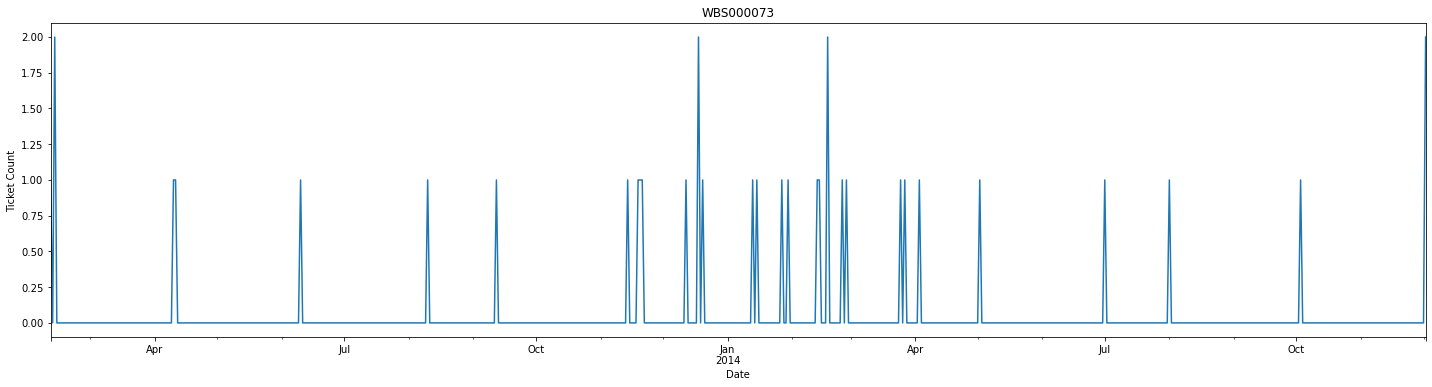

In [127]:
# Plotting all the columns
plot_columns(df_WBS000073,2) #just to adjust the size of the image 2 is passed as argument

We worked on more number of changes between November 2013 and April 2014

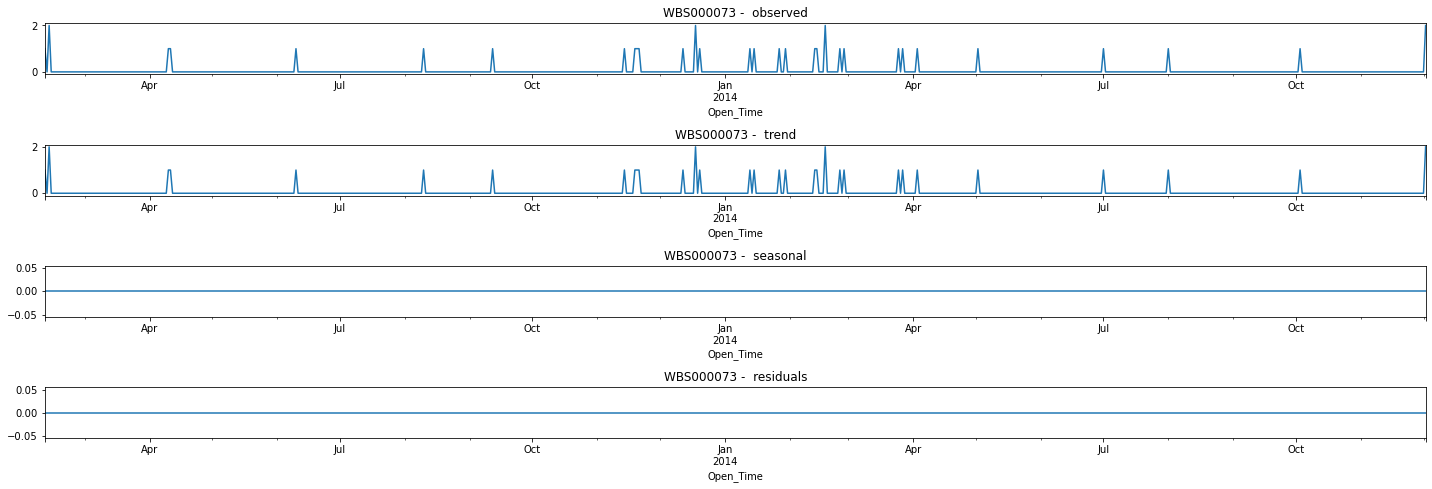

In [128]:
# Seasonal decompose for df_WBS000073
decompose_additive(df_WBS000073,24) #just to adjust the size of the image 24 is passed as argument

Only Trend component is present in the changes for WBS000073, so we can confirm that this is not seasonal data

In [129]:
# Check for stationarity
check_stationarity(df_WBS000073)

WBS000073 - Series is Stationary


In [130]:
# Train and Test split
df_rfc_train = df_WBS000073[:'2014-05-31']
df_rfc_test = df_WBS000073['2014-06-01':]

In [131]:
df_WBS000073.index.min(),df_WBS000073.index.max()

(Timestamp('2013-02-10 00:00:00', freq='D'),
 Timestamp('2014-12-02 00:00:00', freq='D'))

In [132]:
df_rfc_train.tail()

WBS,WBS000073
Open_Time,
2014-05-27,0
2014-05-28,0
2014-05-29,0
2014-05-30,0
2014-05-31,0


In [133]:
df_rfc_test.head()

WBS,WBS000073
Open_Time,
2014-06-01,0
2014-06-02,0
2014-06-03,0
2014-06-04,0
2014-06-05,0


In [134]:
df_rfc_train.shape,df_rfc_test.shape

((476, 1), (185, 1))

In [135]:
df_rfc_train.index.min(),df_rfc_train.index.max()

(Timestamp('2013-02-10 00:00:00', freq='D'),
 Timestamp('2014-05-31 00:00:00', freq='D'))

In [136]:
df_rfc_test.index.min(),df_rfc_test.index.max()

(Timestamp('2014-06-01 00:00:00', freq='D'),
 Timestamp('2014-12-02 00:00:00', freq='D'))

In [137]:
df_rfc_train.columns

Index(['WBS000073'], dtype='object', name='WBS')

###### Model Creation

In [262]:
# Finding out p and q value using auto_arima
stepwise_fit = auto_arima(df_rfc_train['WBS000073'], start_p=0, start_q=0,
                          max_p=10, max_q=10, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=123.846, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=119.776, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=121.646, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=99.287, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=101.208, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=101.196, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=101.243, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=103.200, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=86.651, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=100.191, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=87.713, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=87.924, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.646, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=89.693, Time=0.63 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  476
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -39.326
Date:                Wed, 28 Dec 2022   AIC                             86.651
Time:                        18:55:01   BIC                            103.313
Sample:                    02-10-2013   HQIC                            93.203
                         - 05-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0486      0.033      1.485      0.137      -0.016       0.113
ar.L1          0.0530      0.040      1.324      0.185      -0.025       0.131
ar.L2          0.1812      0.026      6.889      0.000       0.130       0.233
sigma2         0.0691      0.003     21.273      0.000       0.063       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10609.06
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             4.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [264]:
# Model creation
model_sarima = SARIMAX(df_rfc_train, order=(2,0,0))
model_sarimax_fit = model_sarima.fit()

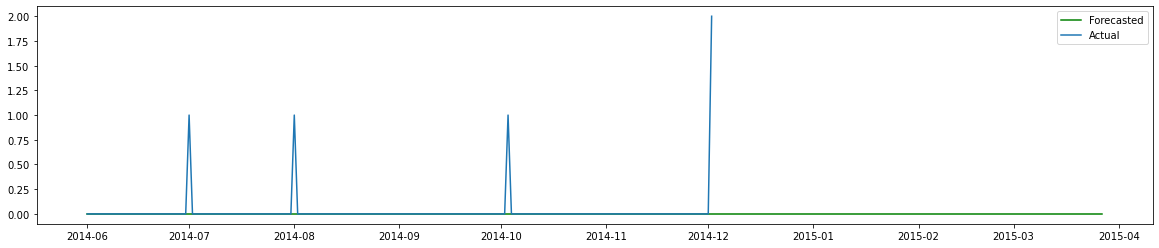

In [267]:
# Forecast and plot the result
sarima_forecast = model_sarimax_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(sarima_forecast,color='green')
plt.plot(df_rfc_test)
plt.legend(['Forecasted','Actual'])

###### Model is not performing good, so we will find out the P and Q value using PACF and ACF

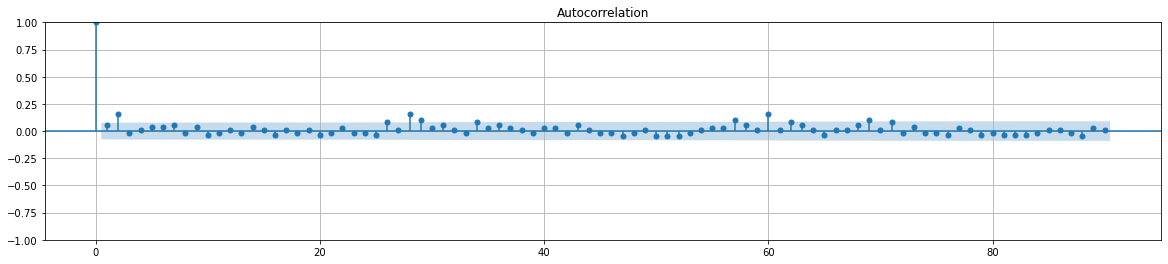

In [269]:
plot_acf(df_WBS000073,lags=90);
plt.grid()

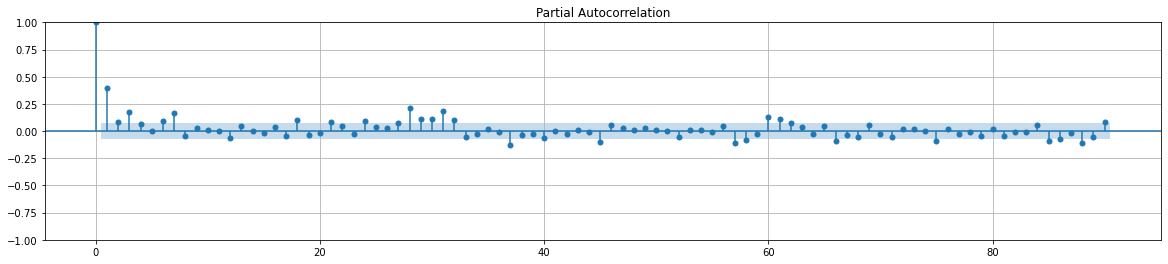

In [270]:
plot_pacf(df_sample,lags=90);
plt.grid()

In [276]:
# Hypertuning p and q value using for loop
p_values = [1,3,7,28,29,30,31,32,61]
q_values = [2,28,29,60]

for p in p_values:
    for q in q_values:
        model = sm.tsa.arima.ARIMA(df_rfc_train, order=(p,0,q))
        model_arima_fit = model.fit()
        arima_predict = model_arima_fit.forecast(steps=len(df_rfc_test))
        print(f"RMSE with {p} and {q}: ",sqrt(mean_squared_error(df_rfc_test,arima_predict)))

RMSE with 1 and 2:  0.19594773021348985
RMSE with 1 and 28:  0.19549341535591214
RMSE with 1 and 29:  0.19546527528590685
RMSE with 1 and 60:  0.19661686734256273
RMSE with 3 and 2:  0.19594581090447735
RMSE with 3 and 28:  0.19544486592110202
RMSE with 3 and 29:  0.19509373075408745
RMSE with 3 and 60:  0.1955577284807336
RMSE with 7 and 2:  0.1959739722137202
RMSE with 7 and 28:  0.1962889469348929
RMSE with 7 and 29:  0.19577189921376933
RMSE with 7 and 60:  0.2010021627896123
RMSE with 28 and 2:  0.19533282942655214
RMSE with 28 and 28:  0.20652116739996945
RMSE with 28 and 29:  0.2003204013146782
RMSE with 28 and 60:  0.20122325504529287
RMSE with 29 and 2:  0.19514679699959567
RMSE with 29 and 28:  0.20203553287251055
RMSE with 29 and 29:  0.21203753087568128
RMSE with 29 and 60:  0.20153120399376406
RMSE with 30 and 2:  0.19514583219735038
RMSE with 30 and 28:  0.21454706907860727
RMSE with 30 and 29:  0.21328604153943015
RMSE with 30 and 60:  0.20176093092182476
RMSE with 31 an

In [278]:
# Model Creation
model = sm.tsa.arima.ARIMA(df_rfc_train, order=(61,0,2))
model_arima_fit = model.fit()

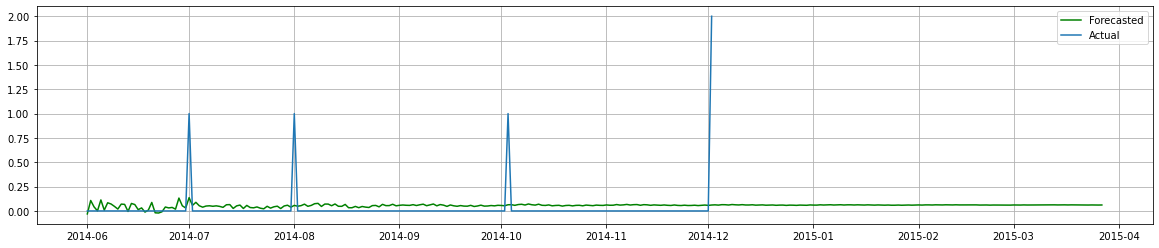

In [279]:
# Forecast and plot the result
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_rfc_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

Model is not performing good.

In [280]:
# Using one of the better model found by hypertuning
model = sm.tsa.arima.ARIMA(df_rfc_train, order=(31,0,2))
model_arima_fit = model.fit()

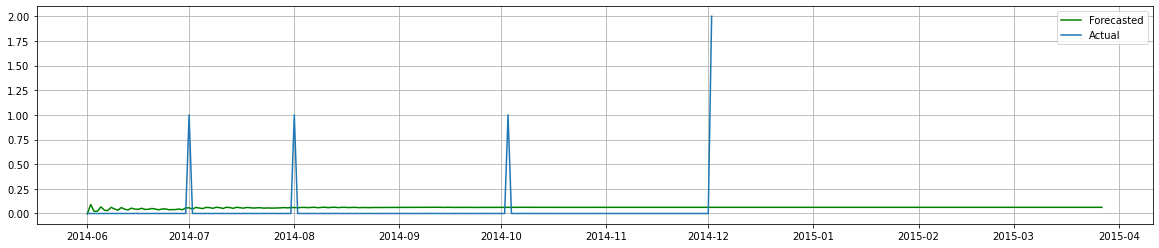

In [281]:
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_rfc_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

Model is not performing good

In [159]:
# Using one of the better model found by hypertuning
model = sm.tsa.arima.ARIMA(df_rfc_train, order=(61,0,29))
model_arima_fit = model.fit()

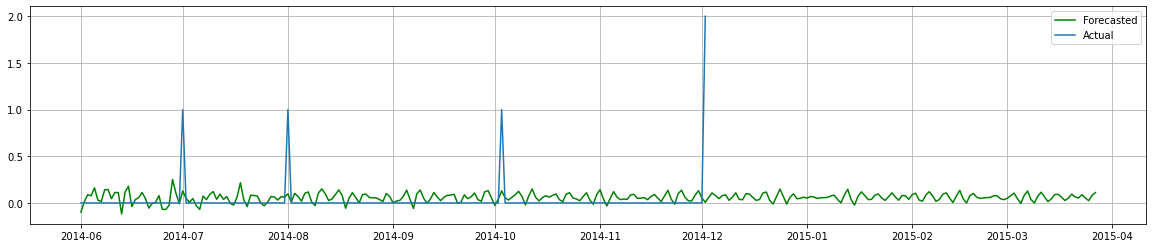

In [160]:
# Forecast and plot the result
arima_predict = model_arima_fit.forecast(steps=300)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(arima_predict,color='green')
plt.plot(df_rfc_test)
plt.grid()
plt.legend(['Forecasted','Actual'])

In [161]:
print("RMSE : ",sqrt(mean_squared_error(df_rfc_test,arima_predict[:len(df_rfc_test)])))

RMSE :  0.20040594030551867


ARIMA Model is not performing good

#### Using  Prophet

In [162]:
# Creating dataframe as required by Prophet library
df = df_WBS000073.reset_index()
df.columns = ['ds','y']

In [163]:
df.head()

,ds,y
0,2013-02-10,1
1,2013-02-11,0
2,2013-02-12,2
3,2013-02-13,0
4,2013-02-14,0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      661 non-null    datetime64[ns]
 1   y       661 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.5 KB


In [166]:
# Train and test split
train = df[:len(df_rfc_train)]
test = df[len(df_rfc_train):]

In [167]:
train.head()

,ds,y
0,2013-02-10,1
1,2013-02-11,0
2,2013-02-12,2
3,2013-02-13,0
4,2013-02-14,0


In [168]:
test.head()

,ds,y
476,2014-06-01,0
477,2014-06-02,0
478,2014-06-03,0
479,2014-06-04,0
480,2014-06-05,0


In [169]:
# Model Creation and Forecast the data
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=300,freq='D')
forecast = m.predict(future)

09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing


In [170]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
771,2015-03-23,0.131897,-0.233876,0.437980,0.129743,0.134086,-0.018646,-0.018646,-0.018646,-0.018646,-0.018646,-0.018646,0.0,0.0,0.0,0.113251
772,2015-03-24,0.132027,-0.161623,0.515677,0.129864,0.134224,0.040019,0.040019,0.040019,0.040019,0.040019,0.040019,0.0,0.0,0.0,0.172047
773,2015-03-25,0.132157,-0.194917,0.466708,0.129990,0.134360,0.010499,0.010499,0.010499,0.010499,0.010499,0.010499,0.0,0.0,0.0,0.142656
774,2015-03-26,0.132288,-0.140383,0.551882,0.130116,0.134495,0.083861,0.083861,0.083861,0.083861,0.083861,0.083861,0.0,0.0,0.0,0.216149
775,2015-03-27,0.132418,-0.229904,0.431915,0.130242,0.134631,-0.019148,-0.019148,-0.019148,-0.019148,-0.019148,-0.019148,0.0,0.0,0.0,0.113270


<AxesSubplot:xlabel='ds'>

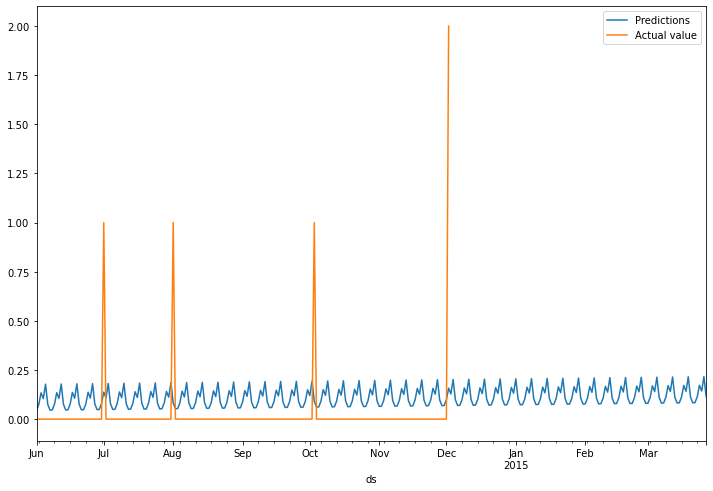

In [171]:
# Plotting the result
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
df.plot(x='ds',y='y',label='Actual value',legend=True,ax=ax,xlim=('2014-06-01','2015-03-27'))

In [172]:
df_rfc_test.shape

(185, 1)

In [174]:
# Evaluating the model
forecasted = forecast.yhat[len(df_rfc_train):len(df_WBS000073)]
print("RMSE : ",sqrt(mean_squared_error(df_rfc_test,forecasted)))

RMSE :  0.2102821602050939


#### Using Long Short Term Memory (LSTM) Networks

In [175]:
# Scaling the data using Minmax scaler
scaler1 = MinMaxScaler()
scaler1.fit(df_rfc_train)
scaled_train = scaler1.transform(df_rfc_train)
scaled_test = scaler1.transform(df_rfc_test)

In [176]:
# Using time generator to create input
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [177]:
len(scaled_train)

476

In [178]:
len(generator) # n_input = 30

446

In [179]:
# Looking at 1st batch 
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Predict this y: 
 [[0.]]


In [181]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [182]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
446/446 [==============================] - 9s 12ms/step - loss: 0.0167
Epoch 2/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0164
Epoch 3/50
446/446 [==============================] - 6s 14ms/step - loss: 0.0164
Epoch 4/50
446/446 [==============================] - 5s 12ms/step - loss: 0.0163
Epoch 5/50
446/446 [==============================] - 5s 12ms/step - loss: 0.0164
Epoch 6/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0163
Epoch 7/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0163
Epoch 8/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0162
Epoch 9/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0162
Epoch 10/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0163
Epoch 11/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0163
Epoch 12/50
446/446 [==============================] - 5s 11ms/step - loss: 0.0162
Epoch 13/50
4

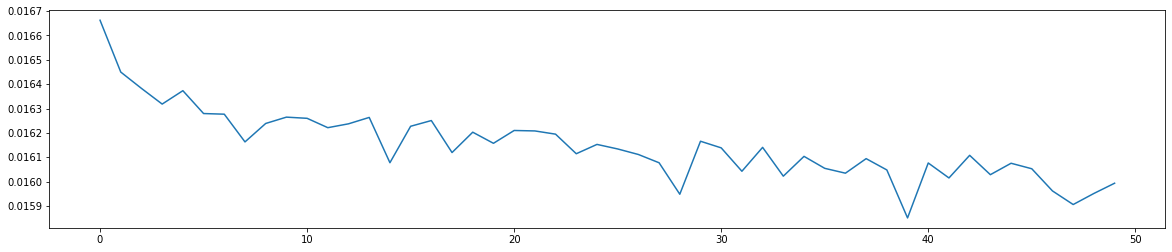

In [183]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [184]:
# Predicting test
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [185]:
test_predictions

[array([0.02341176], dtype=float32),
 array([0.02569626], dtype=float32),
 array([0.02633442], dtype=float32),
 array([0.02648518], dtype=float32),
 array([0.02650466], dtype=float32),
 array([0.02648109], dtype=float32),
 array([0.02644616], dtype=float32),
 array([0.02641214], dtype=float32),
 array([0.0263831], dtype=float32),
 array([0.02635974], dtype=float32),
 array([0.0263415], dtype=float32),
 array([0.02632751], dtype=float32),
 array([0.02631688], dtype=float32),
 array([0.02630886], dtype=float32),
 array([0.02630283], dtype=float32),
 array([0.02629831], dtype=float32),
 array([0.02629494], dtype=float32),
 array([0.02629243], dtype=float32),
 array([0.02629056], dtype=float32),
 array([0.02628917], dtype=float32),
 array([0.02628814], dtype=float32),
 array([0.02628738], dtype=float32),
 array([0.02628681], dtype=float32),
 array([0.0262864], dtype=float32),
 array([0.02628611], dtype=float32),
 array([0.02628591], dtype=float32),
 array([0.02628578], dtype=float32),
 arr

In [186]:
# Evaluate the model performance
true_predictions = scaler1.inverse_transform(test_predictions)
print("RMSE : ",sqrt(mean_squared_error(df_rfc_test,true_predictions[0:len(df_rfc_test)])))

RMSE :  0.19431342512101862


<AxesSubplot:xlabel='Open_Time'>

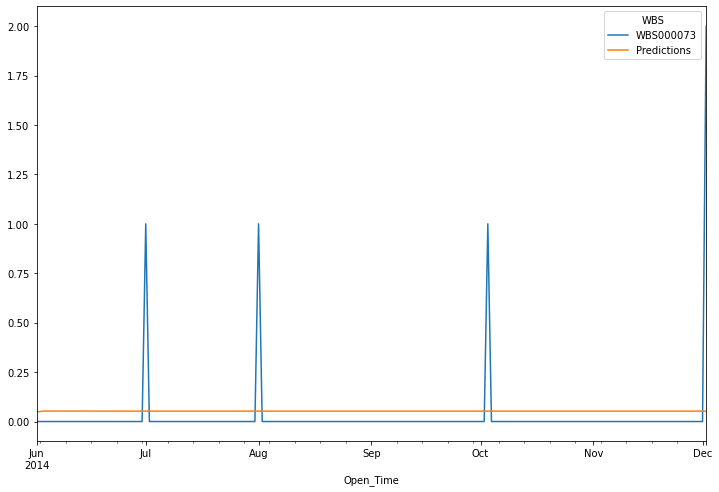

In [187]:
# Adding predictions to df_test dataframe
df_rfc_test['Predictions'] = true_predictions[0:len(df_rfc_test)]

# Visualizing the prediction
df_rfc_test.plot(figsize=(12,8))

##### Using Croston model as the column  have lot of periodic zero data

In [243]:
# Model creation 
fit_pred = croston.fit_croston(df_rfc_train, forecast_length=300)

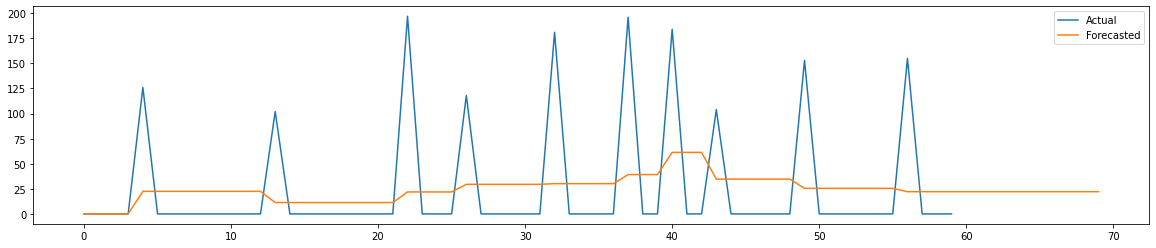

In [244]:
# Plotting the result 
y_hat_fitted = fit_pred['croston_fittedvalues'].tolist()
y_hat_forecasted = fit_pred['croston_forecast'].tolist()
y_hat = y_hat_fitted + y_hat_forecasted
plt.plot(ts)
plt.plot(yhat)
plt.legend(["Actual","Forecasted"])

Croston model is also not performing well

#### ARMA model, Prophet, LSTM and Croston Model didnt perform well as there is uncertainity in the data between November 2013 and March 2014

<AxesSubplot:xlabel='Open_Time'>

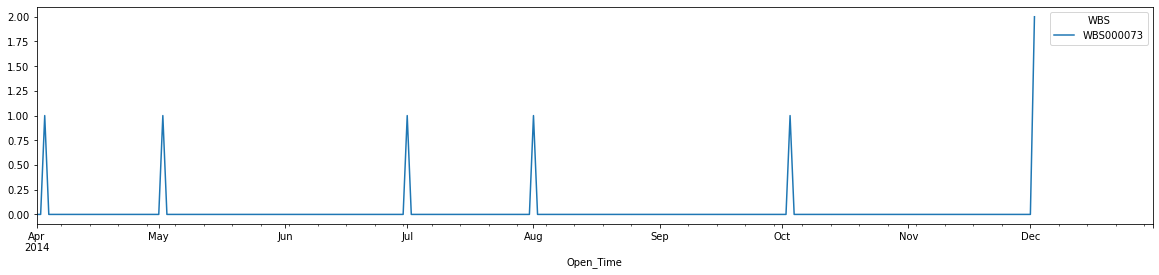

In [260]:
# Visualizing the data from April 2014
df_WBS000073.plot(xlim=("2014-04-01","2014-12-31"))

###### Looks like Changes with WBS000073 are implemented in 1st week of 6 out of 9 months between April and December 2014

In [263]:
df_WBS000073["2014-04-01":].query('WBS000073 > 0 ')

WBS,WBS000073
Open_Time,
2014-04-03,1
2014-05-02,1
2014-07-01,1
2014-08-01,1
2014-10-03,1
2014-12-02,2


#### Based on the above data, we have received incidents with WBS000073 which required change implementation in first three days mostly in every month. So maintenance activity is required for WBS000073 at the end of every month to prevent the incidents which leads to change. 

### Conclusion

Note:
There is no Department column / Work Queue information in the provided data, hence considered CI_Subcat as Department column

###### 1. Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.

* ARMA Model performed better when compared to other models with RMSE score 0.86, Based on the forecast, we might receive   high/critical priority ticket with WBS000146 between 1 to 5th Jan 2015 which will be taken care by Banking Device Department.

    * Features : As we have 412/700 high priority tickets(1 & 2) with WBS000146 where all the incidents belongs to Banking Device Subcategory, forecasted for Banking Device Subcategory only.
    * Frequency :  Daily
    * Models used : ARIMA, Prophet, LSTM, Croston
    * Hypertuning : auto_arima, arma_order_select_ic, Created reusable function to find optimum p,q,d values for ARIMA model 
    * Performance Metrics : RMSE

###### 2. Forecast the incident volume in different fields, quarterly and annual. So that they can be better prepared with resources and technology planning.
* ARIMA Model performs better to forecast the incidents quarterly with respect to CI_Subcat
    1. RMSE for Web Based Application : 108.81
    2. RMSE for Server Based Application : 134.06
    3. RMSE for Laptop : 49.66
    4. RMSE for Desktop Application : 35.27
    5. RMSE for Citrix : 10.77
    6. RMSE for Banking Device : 5.0
    
    
    
* ARIMA Model is used to forecast the incidents annually with respect to CI_Subcat
    1. RMSE for Web Based Application :  78.0
    2. RMSE for Server Based Application :  265.0
    3. RMSE for Laptop :  213.0
    4. RMSE for Desktop Application :  341.99
    5. RMSE for Citrix :  50.0
    6. RMSE for Banking Device :  44.5

    * Features : Incident volumes are considered with respect to CI_Subcat column (only CI_Subcat with more number of ticket volume forecasted)
    * Frequency :  Quarterly, Annual
    * Models used : ARIMA, Prophet, LSTM, Croston
    * Hypertuning : auto_arima, arma_order_select_ic, Created reusable function to find optimum p,q,d values for ARIMA model 
    * Performance Metrics : RMSE

###### 3. Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced.
* Support Vector Machine Classifier model performs better (used Multioutput classifier)
    * Train score :  0.86
    * Test score :  0.78
    * Prediction Accuracy - Priority :  0.99
    * Prediction Accuracy - Department :  0.79

    * Independent Features - 'CI_Cat','WBS', 'Impact', 'Urgency','Category'
    * Dependent Features - 'Priority','CI_Subcat'
    * Data preprocessing : preprocessed using column transformer and pipeline.
            1. CountVectorizer - 'CI_Cat', 'WBS', 'Category'
            2. OneHotEncoder - 'Impact', 'Urgency'
            3. LabelEncoder - 'Priority','CI_Subcat' (not used in column transformer as these are target features)
    * Models used : LogisticRegression, MultinomialNB,SVC, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
    * Hypertuning : Randomizedsearchcv, kfold
    * Performance Metrics : Accuracy

###### 4. Predict RFC (Request for change) and possible failure / misconfiguration of ITSM assets.
* ARMA model, Prophet, LSTM and Croston Model didnt perform well as there is uncertainity in the data between November 2013 and March 2014. Looks like Changes with WBS000073 are implemented in 1st week of 6 out of 9 months between April and December 2014.Based on that data, we have received incidents with WBS000073 which required change implementation in first three days mostly in every month. So maintenance activity is required for WBS000073 at the end of every month to prevent the incidents which leads to change.

    * Features : As we had more number of related change tasks with WBS000073 when compared to others, forecasted the days of occurence based on the change tasks count with respect to WBS000073
    * Frequency : Daily    
    * Models : ARIMA, Prophet, LSTM, Croston
    * Hypertuning : auto_arima, arma_order_select_ic, Created reusable function to find optimum p,q,d values for ARIMA model 
    * Performance Metrics : RMSE